Thanks for;
https://www.kaggle.com/sishihara/moa-lgbm-benchmark#Preprocessing


v1: starter model

v2: compare treat Vs.ctrl and minor modifications, StratifiedKFold

In [1]:
import lightgbm as lgb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from tqdm.notebook import tqdm

In [2]:
train = pd.read_csv("../input/lish-moa/train_features.csv")
test = pd.read_csv("../input/lish-moa/test_features.csv")
train_targets_scored = pd.read_csv("../input/lish-moa/train_targets_scored.csv")
train_targets_nonscored = pd.read_csv("../input/lish-moa/train_targets_nonscored.csv")
sub = pd.read_csv("../input/lish-moa/sample_submission.csv")

In [3]:
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, encode_cols):
    n_train = len(train)
    train = pd.concat([train, test], sort=False).reset_index(drop=True)
    for f in encode_cols:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    return train, test

In [4]:
def run_lgbm(target_col: str):
    
    target = train_targets_scored[target_col]
    ctr = train[train.cp_type==0].copy().reset_index(drop=True)
    trt = train[target==1].copy().reset_index(drop=True)
    trt["target"] = 1
    ctr["target"] = 0

    X_train = pd.concat([trt, ctr],axis=0).reset_index(drop=True)
    y_train = X_train["target"]
    
    X_train = X_train.drop(["sig_id", "target"], axis=1)
    X_test = test.drop(["sig_id"], axis=1)
    
    y_preds = []
    models = []
    oof_train = np.zeros((len(X_train),))
    score = 0
    
    for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train, y_train)):
        print(f"**********fold{fold_id+1}*************")
        X_tr = X_train.loc[train_index, :]
        X_val = X_train.loc[valid_index, :]
        y_tr = y_train[train_index]
        y_val = y_train[valid_index]

        lgb_train = lgb.Dataset(X_tr,
                                y_tr,
                                categorical_feature=categorical_cols)

        lgb_eval = lgb.Dataset(X_val,
                               y_val,
                               reference=lgb_train,
                               categorical_feature=categorical_cols)

        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=100,
                          num_boost_round=10000,
                          early_stopping_rounds=20)
        
        #oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)


        y_pred = model.predict(X_test,
                               num_iteration=model.best_iteration)

        y_preds.append(y_pred)
        models.append(model)
    
    #score = log_loss(y_train, oof_train)

    return sum(y_preds) / len(y_preds), models

In [5]:
def show_feature_importance(feature_importance_df):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:50].index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

    plt.figure(figsize=(8, 16))
    sns.barplot(x="importance", 
                y="Feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Features importance (averaged)')
    plt.tight_layout()
    plt.show()

# Preprocessing

We have to convert some categorical features into numbers in train and test. We can identify categorical features by `pd.DataFrame.select_dtypes`.

In [6]:
train.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [7]:
train.select_dtypes(include=['object']).columns

Index(['sig_id', 'cp_type', 'cp_dose'], dtype='object')

In [8]:
train, test = label_encoding(train, test, ['cp_type', 'cp_dose'])

In [9]:
train.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,1,24,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,1,72,0,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,1,48,0,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,1,48,0,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,1,72,1,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


# Modeling

In [10]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

params = {
    'num_leaves': 24,
    'max_depth': 5,
    'objective': 'binary',
    'learning_rate': 0.03
}

categorical_cols = ['cp_type', 'cp_dose']
feature_importance_df = pd.DataFrame()
models = []

In [11]:
for target_col in tqdm(train_targets_scored.columns[1:]):
    _preds, models = run_lgbm(target_col)

    sub[target_col] = _preds
        
    for model in models:
        _importance_df = pd.DataFrame()
        _importance_df["Feature"] = train.columns[1:]
        _importance_df["importance"] = model.feature_importance(importance_type='gain')
        feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)

**********fold1*************


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00108529	valid_1's binary_logloss: 0.0316847
Early stopping, best iteration is:
[100]	training's binary_logloss: 0.00108529	valid_1's binary_logloss: 0.0316847
**********fold2*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[35]	training's binary_logloss: 0.00777608	valid_1's binary_logloss: 0.0332289
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00118113	valid_1's binary_logloss: 0.0274228
Early stopping, best iteration is:
[88]	training's binary_logloss: 0.0016804	valid_1's binary_logloss: 0.0267675
**********fold4*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[60]	training's binary_logloss: 0.00383197	valid_1's binary_logloss: 0.0318026
**********fold5*************
Training until validatio

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.00690716	valid_1's binary_logloss: 0.0461837
**********fold2*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[12]	training's binary_logloss: 0.020338	valid_1's binary_logloss: 0.0448038
**********fold3*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[75]	training's binary_logloss: 0.00247355	valid_1's binary_logloss: 0.0376765
**********fold4*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00127817	valid_1's binary_logloss: 0.0230834
Early stopping, best iteration is:
[91]	training's binary_logloss: 0.00166478	valid_1's binary_logloss: 0.0227998
**********fold5*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	traini

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0582848	valid_1's binary_logloss: 0.069895
**********fold2*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.0218335	valid_1's binary_logloss: 0.063982
**********fold3*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[41]	training's binary_logloss: 0.0127748	valid_1's binary_logloss: 0.0613611
**********fold4*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[12]	training's binary_logloss: 0.0335853	valid_1's binary_logloss: 0.0571927
**********fold5*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00124446	valid_1's binary_logloss: 0.0011273
[200]	training's binary_logloss: 6.13053e-05	valid

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00829951	valid_1's binary_logloss: 0.00829055
[200]	training's binary_logloss: 0.00040833	valid_1's binary_logloss: 0.000407894
[300]	training's binary_logloss: 2.03178e-05	valid_1's binary_logloss: 2.02961e-05
[400]	training's binary_logloss: 1.21103e-06	valid_1's binary_logloss: 1.20974e-06
Early stopping, best iteration is:
[394]	training's binary_logloss: 1.21103e-06	valid_1's binary_logloss: 1.20974e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00829494	valid_1's binary_logloss: 0.00829719
[200]	training's binary_logloss: 0.000408105	valid_1's binary_logloss: 0.000408214
[300]	training's binary_logloss: 2.03066e-05	valid_1's binary_logloss: 2.0312e-05
[400]	training's binary_logloss: 1.21036e-06	valid_1's binary_logloss: 1.21068e-06
Early stopping, best iteration is:
[401]	training's binary_logloss: 1.210

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0118365	valid_1's binary_logloss: 0.0119101
[200]	training's binary_logloss: 0.000582284	valid_1's binary_logloss: 0.000585858
[300]	training's binary_logloss: 2.89733e-05	valid_1's binary_logloss: 2.9151e-05
[400]	training's binary_logloss: 1.44245e-06	valid_1's binary_logloss: 1.4513e-06
Early stopping, best iteration is:
[410]	training's binary_logloss: 1.15243e-06	valid_1's binary_logloss: 1.1598e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0118782	valid_1's binary_logloss: 0.0118492
[200]	training's binary_logloss: 0.000584335	valid_1's binary_logloss: 0.000582924
[300]	training's binary_logloss: 2.90753e-05	valid_1's binary_logloss: 2.90051e-05
[400]	training's binary_logloss: 1.44753e-06	valid_1's binary_logloss: 1.44404e-06
Early stopping, best iteration is:
[408]	training's binary_logloss: 1.13867e-0

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00353053	valid_1's binary_logloss: 0.00358694
[200]	training's binary_logloss: 0.000173754	valid_1's binary_logloss: 0.000176496
[300]	training's binary_logloss: 8.64582e-06	valid_1's binary_logloss: 8.78222e-06
Early stopping, best iteration is:
[366]	training's binary_logloss: 1.28689e-06	valid_1's binary_logloss: 1.30955e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00353053	valid_1's binary_logloss: 0.00358694
[200]	training's binary_logloss: 0.000173754	valid_1's binary_logloss: 0.000176496
[300]	training's binary_logloss: 8.64582e-06	valid_1's binary_logloss: 8.78222e-06
Early stopping, best iteration is:
[366]	training's binary_logloss: 1.28678e-06	valid_1's binary_logloss: 1.30946e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglo

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0026585	valid_1's binary_logloss: 0.0026879
[200]	training's binary_logloss: 0.000130855	valid_1's binary_logloss: 0.000132285
[300]	training's binary_logloss: 6.51126e-06	valid_1's binary_logloss: 6.58238e-06
Early stopping, best iteration is:
[358]	training's binary_logloss: 1.29834e-06	valid_1's binary_logloss: 1.32131e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0026585	valid_1's binary_logloss: 0.0026879
[200]	training's binary_logloss: 0.000130855	valid_1's binary_logloss: 0.000132285
[300]	training's binary_logloss: 6.51126e-06	valid_1's binary_logloss: 6.58238e-06
Early stopping, best iteration is:
[358]	training's binary_logloss: 1.29919e-06	valid_1's binary_logloss: 1.31888e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00453327	valid_1's binary_logloss: 0.00464061
[200]	training's binary_logloss: 0.00022308	valid_1's binary_logloss: 0.000228299
[300]	training's binary_logloss: 1.11002e-05	valid_1's binary_logloss: 1.13597e-05
Early stopping, best iteration is:
[373]	training's binary_logloss: 1.27212e-06	valid_1's binary_logloss: 1.30403e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00459043	valid_1's binary_logloss: 0.00455852
[200]	training's binary_logloss: 0.000225892	valid_1's binary_logloss: 0.000224341
[300]	training's binary_logloss: 1.12401e-05	valid_1's binary_logloss: 1.1163e-05
Early stopping, best iteration is:
[376]	training's binary_logloss: 1.27024e-06	valid_1's binary_logloss: 1.2665e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss:

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[77]	training's binary_logloss: 0.00155005	valid_1's binary_logloss: 0.0333987
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.000794552	valid_1's binary_logloss: 0.0266611
Early stopping, best iteration is:
[117]	training's binary_logloss: 0.000485934	valid_1's binary_logloss: 0.0264653
**********fold3*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[61]	training's binary_logloss: 0.00264159	valid_1's binary_logloss: 0.0200228
**********fold4*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[34]	training's binary_logloss: 0.00614821	valid_1's binary_logloss: 0.0253152
**********fold5*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[26]	

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0109526	valid_1's binary_logloss: 0.0109417
[200]	training's binary_logloss: 0.000538812	valid_1's binary_logloss: 0.000538284
[300]	training's binary_logloss: 2.68102e-05	valid_1's binary_logloss: 2.6784e-05
[400]	training's binary_logloss: 1.33476e-06	valid_1's binary_logloss: 1.33346e-06
Early stopping, best iteration is:
[410]	training's binary_logloss: 1.16844e-06	valid_1's binary_logloss: 1.17034e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0109471	valid_1's binary_logloss: 0.0109498
[200]	training's binary_logloss: 0.00053854	valid_1's binary_logloss: 0.000538673
[300]	training's binary_logloss: 2.67967e-05	valid_1's binary_logloss: 2.68033e-05
[400]	training's binary_logloss: 1.33409e-06	valid_1's binary_logloss: 1.33442e-06
Early stopping, best iteration is:
[412]	training's binary_logloss: 1.16781e-

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.013469	valid_1's binary_logloss: 0.0134568
[200]	training's binary_logloss: 0.000662564	valid_1's binary_logloss: 0.000661976
[300]	training's binary_logloss: 3.29677e-05	valid_1's binary_logloss: 3.29385e-05
[400]	training's binary_logloss: 1.64132e-06	valid_1's binary_logloss: 1.63986e-06
Early stopping, best iteration is:
[428]	training's binary_logloss: 1.11127e-06	valid_1's binary_logloss: 1.11028e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0134628	valid_1's binary_logloss: 0.0134658
[200]	training's binary_logloss: 0.000662262	valid_1's binary_logloss: 0.000662409
[300]	training's binary_logloss: 3.29527e-05	valid_1's binary_logloss: 3.296e-05
[400]	training's binary_logloss: 1.64057e-06	valid_1's binary_logloss: 1.64093e-06
Early stopping, best iteration is:
[413]	training's binary_logloss: 1.11076e-0

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00318583	valid_1's binary_logloss: 0.0032988
[200]	training's binary_logloss: 0.000156796	valid_1's binary_logloss: 0.00016229
[300]	training's binary_logloss: 7.80207e-06	valid_1's binary_logloss: 8.07527e-06
Early stopping, best iteration is:
[362]	training's binary_logloss: 1.28198e-06	valid_1's binary_logloss: 1.32624e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00324571	valid_1's binary_logloss: 0.00321378
[200]	training's binary_logloss: 0.000159742	valid_1's binary_logloss: 0.000158189
[300]	training's binary_logloss: 7.94863e-06	valid_1's binary_logloss: 7.87143e-06
Early stopping, best iteration is:
[362]	training's binary_logloss: 1.28239e-06	valid_1's binary_logloss: 1.27311e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[21]	training's binary_logloss: 0.00491153	valid_1's binary_logloss: 0.0164329
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00045361	valid_1's binary_logloss: 0.00418005
Early stopping, best iteration is:
[174]	training's binary_logloss: 5.48108e-05	valid_1's binary_logloss: 0.00335469
**********fold3*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.00308718	valid_1's binary_logloss: 0.00962609
**********fold4*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[69]	training's binary_logloss: 0.00136856	valid_1's binary_logloss: 0.00535219
**********fold5*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00205708	valid_1's binary_logloss: 0.00214479
[200]	training's binary_logloss: 0.00010127	valid_1's binary_logloss: 0.000105536
[300]	training's binary_logloss: 5.03916e-06	valid_1's binary_logloss: 5.25134e-06
Early stopping, best iteration is:
[347]	training's binary_logloss: 1.30699e-06	valid_1's binary_logloss: 1.36993e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00205708	valid_1's binary_logloss: 0.00214479
[200]	training's binary_logloss: 0.00010127	valid_1's binary_logloss: 0.000105536
[300]	training's binary_logloss: 5.03916e-06	valid_1's binary_logloss: 5.25134e-06
Early stopping, best iteration is:
[347]	training's binary_logloss: 1.30188e-06	valid_1's binary_logloss: 1.38473e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.0220069	valid_1's binary_logloss: 0.0432311
**********fold2*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0328302	valid_1's binary_logloss: 0.047102
**********fold3*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[41]	training's binary_logloss: 0.00551107	valid_1's binary_logloss: 0.0296234
**********fold4*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.034851	valid_1's binary_logloss: 0.0335132
**********fold5*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0321648	valid_1's binary_logloss: 0.0334744
**********fold1****

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.0198696	valid_1's binary_logloss: 0.0457595
**********fold2*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0314509	valid_1's binary_logloss: 0.0449852
**********fold3*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[64]	training's binary_logloss: 0.00271797	valid_1's binary_logloss: 0.0240275
**********fold4*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0376161	valid_1's binary_logloss: 0.0320941
**********fold5*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[11]	training's binary_logloss: 0.0168139	valid_1's binary_logloss: 0.0307845
**********fold1*

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00235994	valid_1's binary_logloss: 0.00241832
[200]	training's binary_logloss: 0.000116168	valid_1's binary_logloss: 0.000119007
[300]	training's binary_logloss: 5.78047e-06	valid_1's binary_logloss: 5.92168e-06
Early stopping, best iteration is:
[352]	training's binary_logloss: 1.299e-06	valid_1's binary_logloss: 1.34139e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00235994	valid_1's binary_logloss: 0.00241832
[200]	training's binary_logloss: 0.000116168	valid_1's binary_logloss: 0.000119007
[300]	training's binary_logloss: 5.78047e-06	valid_1's binary_logloss: 5.92168e-06
Early stopping, best iteration is:
[352]	training's binary_logloss: 1.30411e-06	valid_1's binary_logloss: 1.34022e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00425935	valid_1's binary_logloss: 0.00428749
[200]	training's binary_logloss: 0.000209606	valid_1's binary_logloss: 0.000210974
[300]	training's binary_logloss: 1.04298e-05	valid_1's binary_logloss: 1.04978e-05
Early stopping, best iteration is:
[371]	training's binary_logloss: 1.27716e-06	valid_1's binary_logloss: 1.28549e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00425935	valid_1's binary_logloss: 0.00428749
[200]	training's binary_logloss: 0.000209606	valid_1's binary_logloss: 0.000210974
[300]	training's binary_logloss: 1.04298e-05	valid_1's binary_logloss: 1.04978e-05
Early stopping, best iteration is:
[374]	training's binary_logloss: 1.27716e-06	valid_1's binary_logloss: 1.28549e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglo

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00387234	valid_1's binary_logloss: 0.00386767
[200]	training's binary_logloss: 0.000190568	valid_1's binary_logloss: 0.000190341
[300]	training's binary_logloss: 9.48248e-06	valid_1's binary_logloss: 9.47117e-06
Early stopping, best iteration is:
[370]	training's binary_logloss: 1.28047e-06	valid_1's binary_logloss: 1.27735e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00386993	valid_1's binary_logloss: 0.00387111
[200]	training's binary_logloss: 0.00019045	valid_1's binary_logloss: 0.000190507
[300]	training's binary_logloss: 9.47659e-06	valid_1's binary_logloss: 9.47942e-06
Early stopping, best iteration is:
[372]	training's binary_logloss: 1.28279e-06	valid_1's binary_logloss: 1.29072e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglos

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00174939	valid_1's binary_logloss: 0.00186648
[200]	training's binary_logloss: 8.6135e-05	valid_1's binary_logloss: 9.18318e-05
[300]	training's binary_logloss: 4.2861e-06	valid_1's binary_logloss: 4.5694e-06
Early stopping, best iteration is:
[341]	training's binary_logloss: 1.30701e-06	valid_1's binary_logloss: 1.40667e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00181256	valid_1's binary_logloss: 0.00178116
[200]	training's binary_logloss: 8.92418e-05	valid_1's binary_logloss: 8.7714e-05
[300]	training's binary_logloss: 4.44069e-06	valid_1's binary_logloss: 4.3647e-06
Early stopping, best iteration is:
[347]	training's binary_logloss: 1.3086e-06	valid_1's binary_logloss: 1.29979e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00181136	valid_1's binary_logloss: 0.00189934
[200]	training's binary_logloss: 8.91827e-05	valid_1's binary_logloss: 9.34632e-05
[300]	training's binary_logloss: 4.43774e-06	valid_1's binary_logloss: 4.65062e-06
Early stopping, best iteration is:
[342]	training's binary_logloss: 1.31376e-06	valid_1's binary_logloss: 1.37733e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00181136	valid_1's binary_logloss: 0.00189934
[200]	training's binary_logloss: 8.91827e-05	valid_1's binary_logloss: 9.34632e-05
[300]	training's binary_logloss: 4.43774e-06	valid_1's binary_logloss: 4.65062e-06
Early stopping, best iteration is:
[342]	training's binary_logloss: 1.31167e-06	valid_1's binary_logloss: 1.37803e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglo

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00353053	valid_1's binary_logloss: 0.00358694
[200]	training's binary_logloss: 0.000173754	valid_1's binary_logloss: 0.000176496
[300]	training's binary_logloss: 8.64582e-06	valid_1's binary_logloss: 8.78222e-06
Early stopping, best iteration is:
[368]	training's binary_logloss: 1.2855e-06	valid_1's binary_logloss: 1.30669e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00353053	valid_1's binary_logloss: 0.00358694
[200]	training's binary_logloss: 0.000173754	valid_1's binary_logloss: 0.000176496
[300]	training's binary_logloss: 8.64582e-06	valid_1's binary_logloss: 8.78222e-06
Early stopping, best iteration is:
[366]	training's binary_logloss: 1.2835e-06	valid_1's binary_logloss: 1.30928e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.0113593	valid_1's binary_logloss: 0.0324754
**********fold2*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.017505	valid_1's binary_logloss: 0.0187496
**********fold3*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0191633	valid_1's binary_logloss: 0.0188003
**********fold4*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.017475	valid_1's binary_logloss: 0.0154469
**********fold5*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0174923	valid_1's binary_logloss: 0.018859
**********fold1*******

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00211802	valid_1's binary_logloss: 0.00217668
[200]	training's binary_logloss: 0.000104267	valid_1's binary_logloss: 0.000107121
[300]	training's binary_logloss: 5.18831e-06	valid_1's binary_logloss: 5.33023e-06
Early stopping, best iteration is:
[350]	training's binary_logloss: 1.30579e-06	valid_1's binary_logloss: 1.34855e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00211802	valid_1's binary_logloss: 0.00217668
[200]	training's binary_logloss: 0.000104267	valid_1's binary_logloss: 0.000107121
[300]	training's binary_logloss: 5.18831e-06	valid_1's binary_logloss: 5.33023e-06
Early stopping, best iteration is:
[350]	training's binary_logloss: 1.30599e-06	valid_1's binary_logloss: 1.34621e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglo

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[22]	training's binary_logloss: 0.00923005	valid_1's binary_logloss: 0.0468505
**********fold2*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[14]	training's binary_logloss: 0.0120853	valid_1's binary_logloss: 0.0367086
**********fold3*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[53]	training's binary_logloss: 0.00349444	valid_1's binary_logloss: 0.0293364
**********fold4*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.000854734	valid_1's binary_logloss: 0.0259794
Early stopping, best iteration is:
[144]	training's binary_logloss: 0.000246402	valid_1's binary_logloss: 0.0253128
**********fold5*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[47]	t

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[63]	training's binary_logloss: 0.0025624	valid_1's binary_logloss: 0.0293153
**********fold2*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[54]	training's binary_logloss: 0.00332171	valid_1's binary_logloss: 0.0321199
**********fold3*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[24]	training's binary_logloss: 0.0090363	valid_1's binary_logloss: 0.0409726
**********fold4*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.000947838	valid_1's binary_logloss: 0.0209758
Early stopping, best iteration is:
[105]	training's binary_logloss: 0.00081974	valid_1's binary_logloss: 0.0207377
**********fold5*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00095719

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[10]	training's binary_logloss: 0.0152964	valid_1's binary_logloss: 0.0469173
**********fold2*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.0292659	valid_1's binary_logloss: 0.0458821
**********fold3*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.036008	valid_1's binary_logloss: 0.0335882
**********fold4*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0361502	valid_1's binary_logloss: 0.0336511
**********fold5*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.0215612	valid_1's binary_logloss: 0.0320504
**********fold1****

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[22]	training's binary_logloss: 0.0148763	valid_1's binary_logloss: 0.0430823
**********fold2*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[58]	training's binary_logloss: 0.00455364	valid_1's binary_logloss: 0.0380968
**********fold3*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[71]	training's binary_logloss: 0.00335981	valid_1's binary_logloss: 0.0252292
**********fold4*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0483876	valid_1's binary_logloss: 0.0468042
**********fold5*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[68]	training's binary_logloss: 0.0039314	valid_1's binary_logloss: 0.0283248
**********fol

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00353053	valid_1's binary_logloss: 0.00358694
[200]	training's binary_logloss: 0.000173754	valid_1's binary_logloss: 0.000176496
[300]	training's binary_logloss: 8.64582e-06	valid_1's binary_logloss: 8.78222e-06
Early stopping, best iteration is:
[366]	training's binary_logloss: 1.28506e-06	valid_1's binary_logloss: 1.3097e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00353053	valid_1's binary_logloss: 0.00358694
[200]	training's binary_logloss: 0.000173754	valid_1's binary_logloss: 0.000176496
[300]	training's binary_logloss: 8.64582e-06	valid_1's binary_logloss: 8.78222e-06
Early stopping, best iteration is:
[365]	training's binary_logloss: 1.28891e-06	valid_1's binary_logloss: 1.3135e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00174939	valid_1's binary_logloss: 0.00186648
[200]	training's binary_logloss: 8.6135e-05	valid_1's binary_logloss: 9.18318e-05
[300]	training's binary_logloss: 4.2861e-06	valid_1's binary_logloss: 4.5694e-06
Early stopping, best iteration is:
[350]	training's binary_logloss: 1.30975e-06	valid_1's binary_logloss: 1.41313e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00181256	valid_1's binary_logloss: 0.00178116
[200]	training's binary_logloss: 8.92418e-05	valid_1's binary_logloss: 8.7714e-05
[300]	training's binary_logloss: 4.44069e-06	valid_1's binary_logloss: 4.3647e-06
Early stopping, best iteration is:
[343]	training's binary_logloss: 1.31219e-06	valid_1's binary_logloss: 1.30486e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[37]	training's binary_logloss: 0.0112628	valid_1's binary_logloss: 0.0554394
**********fold2*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[32]	training's binary_logloss: 0.0131233	valid_1's binary_logloss: 0.0615936
**********fold3*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[9]	training's binary_logloss: 0.033612	valid_1's binary_logloss: 0.0688265
**********fold4*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00208538	valid_1's binary_logloss: 0.037315
Early stopping, best iteration is:
[101]	training's binary_logloss: 0.00203145	valid_1's binary_logloss: 0.0372068
**********fold5*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2]	training'

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00241999	valid_1's binary_logloss: 0.00244953
[200]	training's binary_logloss: 0.000119122	valid_1's binary_logloss: 0.000120559
[300]	training's binary_logloss: 5.92744e-06	valid_1's binary_logloss: 5.99891e-06
Early stopping, best iteration is:
[352]	training's binary_logloss: 1.30138e-06	valid_1's binary_logloss: 1.31972e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00241999	valid_1's binary_logloss: 0.00244953
[200]	training's binary_logloss: 0.000119122	valid_1's binary_logloss: 0.000120559
[300]	training's binary_logloss: 5.92744e-06	valid_1's binary_logloss: 5.99891e-06
Early stopping, best iteration is:
[352]	training's binary_logloss: 1.29737e-06	valid_1's binary_logloss: 1.33618e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglo

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00229972	valid_1's binary_logloss: 0.002387
[200]	training's binary_logloss: 0.000113206	valid_1's binary_logloss: 0.000117451
[300]	training's binary_logloss: 5.63308e-06	valid_1's binary_logloss: 5.84418e-06
Early stopping, best iteration is:
[352]	training's binary_logloss: 1.30622e-06	valid_1's binary_logloss: 1.3764e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00229972	valid_1's binary_logloss: 0.002387
[200]	training's binary_logloss: 0.000113206	valid_1's binary_logloss: 0.000117451
[300]	training's binary_logloss: 5.63308e-06	valid_1's binary_logloss: 5.84418e-06
Early stopping, best iteration is:
[353]	training's binary_logloss: 1.30605e-06	valid_1's binary_logloss: 1.38092e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[48]	training's binary_logloss: 0.00153241	valid_1's binary_logloss: 0.0281491
**********fold2*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[36]	training's binary_logloss: 0.0028084	valid_1's binary_logloss: 0.0129172
**********fold3*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[63]	training's binary_logloss: 0.00125894	valid_1's binary_logloss: 0.0123907
**********fold4*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[54]	training's binary_logloss: 0.00164708	valid_1's binary_logloss: 0.0106011
**********fold5*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.000426034	valid_1's binary_logloss: 0.00411909
Early stopping, best iteration is:
[120]	t

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0	valid_1's binary_logloss: 0.0923497
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 8.80951e-05	valid_1's binary_logloss: 4.19126e-05
[200]	training's binary_logloss: 5.21579e-06	valid_1's binary_logloss: 2.43089e-06
Early stopping, best iteration is:
[250]	training's binary_logloss: 1.33353e-06	valid_1's binary_logloss: 6.1171e-07
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 8.76183e-05	valid_1's binary_logloss: 5.46634e-05
[200]	training's binary_logloss: 5.14709e-06	valid_1's binary_logloss: 4.64408e-06
Early stopping, best iteration is:
[249]	training's binary_logloss: 1.30913e-06	valid_1's binary_logloss: 1.6345e-06
**********fold4*************
Training until validation scores don't improve for 20 rounds

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.00430025	valid_1's binary_logloss: 0.0135808
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.000774819	valid_1's binary_logloss: 0.00528495
Early stopping, best iteration is:
[99]	training's binary_logloss: 0.0007984	valid_1's binary_logloss: 0.00522565
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.000855341	valid_1's binary_logloss: 0.00117973
[200]	training's binary_logloss: 4.73824e-05	valid_1's binary_logloss: 0.000324622
[300]	training's binary_logloss: 3.23901e-06	valid_1's binary_logloss: 9.61678e-05
Early stopping, best iteration is:
[306]	training's binary_logloss: 2.8262e-06	valid_1's binary_logloss: 9.03841e-05
**********fold4*************
Training until validation scores don't improve for 20 r

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00458763	valid_1's binary_logloss: 0.00466835
[200]	training's binary_logloss: 0.000225754	valid_1's binary_logloss: 0.000229679
[300]	training's binary_logloss: 1.12333e-05	valid_1's binary_logloss: 1.14284e-05
Early stopping, best iteration is:
[374]	training's binary_logloss: 1.27237e-06	valid_1's binary_logloss: 1.30668e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00458763	valid_1's binary_logloss: 0.00466835
[200]	training's binary_logloss: 0.000225754	valid_1's binary_logloss: 0.000229679
[300]	training's binary_logloss: 1.12333e-05	valid_1's binary_logloss: 1.14284e-05
Early stopping, best iteration is:
[375]	training's binary_logloss: 1.26633e-06	valid_1's binary_logloss: 1.29295e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglo

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00131769	valid_1's binary_logloss: 0.0214852
Early stopping, best iteration is:
[141]	training's binary_logloss: 0.000398685	valid_1's binary_logloss: 0.0205265
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00128341	valid_1's binary_logloss: 0.0232399
Early stopping, best iteration is:
[106]	training's binary_logloss: 0.0010782	valid_1's binary_logloss: 0.0228388
**********fold3*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[59]	training's binary_logloss: 0.00414302	valid_1's binary_logloss: 0.0200879
**********fold4*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00128474	valid_1's binary_logloss: 0.0159204
Early stopping, best iteration is:
[112]	training's binary_logloss: 0.000908248	valid

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00453327	valid_1's binary_logloss: 0.00464061
[200]	training's binary_logloss: 0.00022308	valid_1's binary_logloss: 0.000228299
[300]	training's binary_logloss: 1.11002e-05	valid_1's binary_logloss: 1.13597e-05
Early stopping, best iteration is:
[373]	training's binary_logloss: 1.26072e-06	valid_1's binary_logloss: 1.29646e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00459043	valid_1's binary_logloss: 0.00455852
[200]	training's binary_logloss: 0.000225892	valid_1's binary_logloss: 0.000224341
[300]	training's binary_logloss: 1.12401e-05	valid_1's binary_logloss: 1.1163e-05
Early stopping, best iteration is:
[374]	training's binary_logloss: 1.26161e-06	valid_1's binary_logloss: 1.25485e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.00844332	valid_1's binary_logloss: 0.0331423
**********fold2*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.00262172	valid_1's binary_logloss: 0.0133604
**********fold3*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0177143	valid_1's binary_logloss: 0.0177433
**********fold4*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0196681	valid_1's binary_logloss: 0.0186952
**********fold5*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.0126186	valid_1's binary_logloss: 0.0180636
**********fold1*

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00295489	valid_1's binary_logloss: 0.00295126
[200]	training's binary_logloss: 0.000145436	valid_1's binary_logloss: 0.000145259
[300]	training's binary_logloss: 7.23679e-06	valid_1's binary_logloss: 7.228e-06
Early stopping, best iteration is:
[359]	training's binary_logloss: 1.29598e-06	valid_1's binary_logloss: 1.28739e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00295301	valid_1's binary_logloss: 0.00295392
[200]	training's binary_logloss: 0.000145343	valid_1's binary_logloss: 0.000145388
[300]	training's binary_logloss: 7.23218e-06	valid_1's binary_logloss: 7.23438e-06
Early stopping, best iteration is:
[359]	training's binary_logloss: 1.28963e-06	valid_1's binary_logloss: 1.3045e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss:

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00387234	valid_1's binary_logloss: 0.00386767
[200]	training's binary_logloss: 0.000190568	valid_1's binary_logloss: 0.000190341
[300]	training's binary_logloss: 9.48248e-06	valid_1's binary_logloss: 9.47117e-06
Early stopping, best iteration is:
[371]	training's binary_logloss: 1.28319e-06	valid_1's binary_logloss: 1.29196e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00386993	valid_1's binary_logloss: 0.00387111
[200]	training's binary_logloss: 0.00019045	valid_1's binary_logloss: 0.000190507
[300]	training's binary_logloss: 9.47659e-06	valid_1's binary_logloss: 9.47942e-06
Early stopping, best iteration is:
[371]	training's binary_logloss: 1.28199e-06	valid_1's binary_logloss: 1.28795e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglos

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00174939	valid_1's binary_logloss: 0.00186648
[200]	training's binary_logloss: 8.6135e-05	valid_1's binary_logloss: 9.18318e-05
[300]	training's binary_logloss: 4.2861e-06	valid_1's binary_logloss: 4.5694e-06
Early stopping, best iteration is:
[340]	training's binary_logloss: 1.31469e-06	valid_1's binary_logloss: 1.40209e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00181256	valid_1's binary_logloss: 0.00178116
[200]	training's binary_logloss: 8.92418e-05	valid_1's binary_logloss: 8.7714e-05
[300]	training's binary_logloss: 4.44069e-06	valid_1's binary_logloss: 4.3647e-06
Early stopping, best iteration is:
[342]	training's binary_logloss: 1.30658e-06	valid_1's binary_logloss: 1.30098e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00833976	valid_1's binary_logloss: 0.00840788
[200]	training's binary_logloss: 0.00041031	valid_1's binary_logloss: 0.00041362
[300]	training's binary_logloss: 2.04163e-05	valid_1's binary_logloss: 2.05809e-05
[400]	training's binary_logloss: 1.21103e-06	valid_1's binary_logloss: 1.22127e-06
Early stopping, best iteration is:
[395]	training's binary_logloss: 1.21103e-06	valid_1's binary_logloss: 1.22127e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00833976	valid_1's binary_logloss: 0.00840788
[200]	training's binary_logloss: 0.00041031	valid_1's binary_logloss: 0.00041362
[300]	training's binary_logloss: 2.04163e-05	valid_1's binary_logloss: 2.05809e-05
[400]	training's binary_logloss: 1.2121e-06	valid_1's binary_logloss: 1.2238e-06
Early stopping, best iteration is:
[395]	training's binary_logloss: 1.2121e-0

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00425935	valid_1's binary_logloss: 0.00428749
[200]	training's binary_logloss: 0.000209606	valid_1's binary_logloss: 0.000210974
[300]	training's binary_logloss: 1.04298e-05	valid_1's binary_logloss: 1.04978e-05
Early stopping, best iteration is:
[375]	training's binary_logloss: 1.27716e-06	valid_1's binary_logloss: 1.28549e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00425935	valid_1's binary_logloss: 0.00428749
[200]	training's binary_logloss: 0.000209606	valid_1's binary_logloss: 0.000210974
[300]	training's binary_logloss: 1.04298e-05	valid_1's binary_logloss: 1.04978e-05
Early stopping, best iteration is:
[373]	training's binary_logloss: 1.27716e-06	valid_1's binary_logloss: 1.28549e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglo

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00538991	valid_1's binary_logloss: 0.00538362
[200]	training's binary_logloss: 0.000265218	valid_1's binary_logloss: 0.000264913
[300]	training's binary_logloss: 1.31969e-05	valid_1's binary_logloss: 1.31817e-05
[400]	training's binary_logloss: 1.25746e-06	valid_1's binary_logloss: 1.25901e-06
Early stopping, best iteration is:
[382]	training's binary_logloss: 1.25746e-06	valid_1's binary_logloss: 1.25901e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00538669	valid_1's binary_logloss: 0.00538826
[200]	training's binary_logloss: 0.00026506	valid_1's binary_logloss: 0.000265136
[300]	training's binary_logloss: 1.3189e-05	valid_1's binary_logloss: 1.31928e-05
[400]	training's binary_logloss: 1.25829e-06	valid_1's binary_logloss: 1.25988e-06
Early stopping, best iteration is:
[380]	training's binary_logloss: 1.258

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[62]	training's binary_logloss: 0.00124185	valid_1's binary_logloss: 0.0155203
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.000446067	valid_1's binary_logloss: 0.0013153
[200]	training's binary_logloss: 2.614e-05	valid_1's binary_logloss: 0.000694949
[300]	training's binary_logloss: 2.0241e-06	valid_1's binary_logloss: 0.000228602
Early stopping, best iteration is:
[317]	training's binary_logloss: 1.37291e-06	valid_1's binary_logloss: 0.0001752
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.000566313	valid_1's binary_logloss: 0.000792494
[200]	training's binary_logloss: 3.36532e-05	valid_1's binary_logloss: 9.90763e-05
[300]	training's binary_logloss: 2.64113e-06	valid_1's binary_logloss: 1.7649e-05
Early stopping, best iteration is:
[3

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00149905	valid_1's binary_logloss: 0.00161595
[200]	training's binary_logloss: 7.38228e-05	valid_1's binary_logloss: 7.95124e-05
[300]	training's binary_logloss: 3.67347e-06	valid_1's binary_logloss: 3.95643e-06
Early stopping, best iteration is:
[336]	training's binary_logloss: 1.30325e-06	valid_1's binary_logloss: 1.42796e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0015631	valid_1's binary_logloss: 0.00153199
[200]	training's binary_logloss: 7.69725e-05	valid_1's binary_logloss: 7.54587e-05
[300]	training's binary_logloss: 3.83019e-06	valid_1's binary_logloss: 3.75491e-06
Early stopping, best iteration is:
[337]	training's binary_logloss: 1.30628e-06	valid_1's binary_logloss: 1.27732e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglos

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0018731	valid_1's binary_logloss: 0.00193195
[200]	training's binary_logloss: 9.22196e-05	valid_1's binary_logloss: 9.5083e-05
[300]	training's binary_logloss: 4.58885e-06	valid_1's binary_logloss: 4.73125e-06
Early stopping, best iteration is:
[343]	training's binary_logloss: 1.30995e-06	valid_1's binary_logloss: 1.35986e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0018731	valid_1's binary_logloss: 0.00193195
[200]	training's binary_logloss: 9.22196e-05	valid_1's binary_logloss: 9.5083e-05
[300]	training's binary_logloss: 4.58885e-06	valid_1's binary_logloss: 4.73125e-06
Early stopping, best iteration is:
[343]	training's binary_logloss: 1.30166e-06	valid_1's binary_logloss: 1.37031e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00324366	valid_1's binary_logloss: 0.00332852
[200]	training's binary_logloss: 0.000159641	valid_1's binary_logloss: 0.000163768
[300]	training's binary_logloss: 7.94361e-06	valid_1's binary_logloss: 8.14883e-06
Early stopping, best iteration is:
[363]	training's binary_logloss: 1.289e-06	valid_1's binary_logloss: 1.32981e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00324366	valid_1's binary_logloss: 0.00332852
[200]	training's binary_logloss: 0.000159641	valid_1's binary_logloss: 0.000163768
[300]	training's binary_logloss: 7.94361e-06	valid_1's binary_logloss: 8.14883e-06
Early stopping, best iteration is:
[367]	training's binary_logloss: 1.28767e-06	valid_1's binary_logloss: 1.32741e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[35]	training's binary_logloss: 0.0150275	valid_1's binary_logloss: 0.0609015
**********fold2*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[8]	training's binary_logloss: 0.0382887	valid_1's binary_logloss: 0.0682249
**********fold3*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.0125909	valid_1's binary_logloss: 0.0683986
**********fold4*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.0160991	valid_1's binary_logloss: 0.0682586
**********fold5*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00124446	valid_1's binary_logloss: 0.0011273
[200]	training's binary_logloss: 6.13053e-05	val

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00330133	valid_1's binary_logloss: 0.00335817
[200]	training's binary_logloss: 0.000162478	valid_1's binary_logloss: 0.000165242
[300]	training's binary_logloss: 8.08479e-06	valid_1's binary_logloss: 8.22223e-06
Early stopping, best iteration is:
[362]	training's binary_logloss: 1.28715e-06	valid_1's binary_logloss: 1.30709e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00330133	valid_1's binary_logloss: 0.00335817
[200]	training's binary_logloss: 0.000162478	valid_1's binary_logloss: 0.000165242
[300]	training's binary_logloss: 8.08479e-06	valid_1's binary_logloss: 8.22223e-06
Early stopping, best iteration is:
[362]	training's binary_logloss: 1.28246e-06	valid_1's binary_logloss: 1.30489e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglo

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00143574	valid_1's binary_logloss: 0.00146532
[200]	training's binary_logloss: 7.07098e-05	valid_1's binary_logloss: 7.21494e-05
[300]	training's binary_logloss: 3.51858e-06	valid_1's binary_logloss: 3.59017e-06
Early stopping, best iteration is:
[334]	training's binary_logloss: 1.3078e-06	valid_1's binary_logloss: 1.37211e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00143574	valid_1's binary_logloss: 0.00146532
[200]	training's binary_logloss: 7.07098e-05	valid_1's binary_logloss: 7.21494e-05
[300]	training's binary_logloss: 3.51858e-06	valid_1's binary_logloss: 3.59017e-06
Early stopping, best iteration is:
[335]	training's binary_logloss: 1.31341e-06	valid_1's binary_logloss: 1.34792e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglos

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0160031	valid_1's binary_logloss: 0.0345093
**********fold2*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[31]	training's binary_logloss: 0.00370127	valid_1's binary_logloss: 0.0167557
**********fold3*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[73]	training's binary_logloss: 0.00100638	valid_1's binary_logloss: 0.0130486
**********fold4*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0198084	valid_1's binary_logloss: 0.0186651
**********fold5*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.0154746	valid_1's binary_logloss: 0.0152182
**********fold1

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0112495	valid_1's binary_logloss: 0.0113258
[200]	training's binary_logloss: 0.000553416	valid_1's binary_logloss: 0.000557125
[300]	training's binary_logloss: 2.75368e-05	valid_1's binary_logloss: 2.77213e-05
[400]	training's binary_logloss: 1.37094e-06	valid_1's binary_logloss: 1.38012e-06
Early stopping, best iteration is:
[411]	training's binary_logloss: 1.16455e-06	valid_1's binary_logloss: 1.17784e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0112925	valid_1's binary_logloss: 0.0112631
[200]	training's binary_logloss: 0.000555531	valid_1's binary_logloss: 0.000554101
[300]	training's binary_logloss: 2.76421e-05	valid_1's binary_logloss: 2.7571e-05
[400]	training's binary_logloss: 1.37618e-06	valid_1's binary_logloss: 1.37264e-06
Early stopping, best iteration is:
[406]	training's binary_logloss: 1.14948e

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00205708	valid_1's binary_logloss: 0.00214479
[200]	training's binary_logloss: 0.00010127	valid_1's binary_logloss: 0.000105536
[300]	training's binary_logloss: 5.03916e-06	valid_1's binary_logloss: 5.25134e-06
Early stopping, best iteration is:
[347]	training's binary_logloss: 1.3092e-06	valid_1's binary_logloss: 1.38574e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00205708	valid_1's binary_logloss: 0.00214479
[200]	training's binary_logloss: 0.00010127	valid_1's binary_logloss: 0.000105536
[300]	training's binary_logloss: 5.03916e-06	valid_1's binary_logloss: 5.25134e-06
Early stopping, best iteration is:
[348]	training's binary_logloss: 1.3062e-06	valid_1's binary_logloss: 1.37667e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00271946	valid_1's binary_logloss: 0.0027161
[200]	training's binary_logloss: 0.000133854	valid_1's binary_logloss: 0.000133691
[300]	training's binary_logloss: 6.66049e-06	valid_1's binary_logloss: 6.65237e-06
Early stopping, best iteration is:
[357]	training's binary_logloss: 1.29911e-06	valid_1's binary_logloss: 1.30542e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00271772	valid_1's binary_logloss: 0.00271856
[200]	training's binary_logloss: 0.000133768	valid_1's binary_logloss: 0.000133809
[300]	training's binary_logloss: 6.65622e-06	valid_1's binary_logloss: 6.65826e-06
Early stopping, best iteration is:
[357]	training's binary_logloss: 1.29716e-06	valid_1's binary_logloss: 1.31105e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglos

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00174939	valid_1's binary_logloss: 0.00186648
[200]	training's binary_logloss: 8.6135e-05	valid_1's binary_logloss: 9.18318e-05
[300]	training's binary_logloss: 4.2861e-06	valid_1's binary_logloss: 4.5694e-06
Early stopping, best iteration is:
[341]	training's binary_logloss: 1.31235e-06	valid_1's binary_logloss: 1.40409e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00181256	valid_1's binary_logloss: 0.00178116
[200]	training's binary_logloss: 8.92418e-05	valid_1's binary_logloss: 8.7714e-05
[300]	training's binary_logloss: 4.44069e-06	valid_1's binary_logloss: 4.3647e-06
Early stopping, best iteration is:
[342]	training's binary_logloss: 1.3121e-06	valid_1's binary_logloss: 1.30803e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00174939	valid_1's binary_logloss: 0.00186648
[200]	training's binary_logloss: 8.6135e-05	valid_1's binary_logloss: 9.18318e-05
[300]	training's binary_logloss: 4.2861e-06	valid_1's binary_logloss: 4.5694e-06
Early stopping, best iteration is:
[342]	training's binary_logloss: 1.30671e-06	valid_1's binary_logloss: 1.41307e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00181256	valid_1's binary_logloss: 0.00178116
[200]	training's binary_logloss: 8.92418e-05	valid_1's binary_logloss: 8.7714e-05
[300]	training's binary_logloss: 4.44069e-06	valid_1's binary_logloss: 4.3647e-06
Early stopping, best iteration is:
[343]	training's binary_logloss: 1.31305e-06	valid_1's binary_logloss: 1.28979e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[7]	training's binary_logloss: 0.0298084	valid_1's binary_logloss: 0.0586808
**********fold2*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.0113676	valid_1's binary_logloss: 0.053522
**********fold3*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[52]	training's binary_logloss: 0.00521928	valid_1's binary_logloss: 0.0486901
**********fold4*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[19]	training's binary_logloss: 0.017126	valid_1's binary_logloss: 0.046365
**********fold5*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0502417	valid_1's binary_logloss: 0.0468417
**********fold1***

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.0244136	valid_1's binary_logloss: 0.0470632
**********fold2*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[33]	training's binary_logloss: 0.00603637	valid_1's binary_logloss: 0.0387429
**********fold3*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[60]	training's binary_logloss: 0.00290823	valid_1's binary_logloss: 0.0225684
**********fold4*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[7]	training's binary_logloss: 0.0202751	valid_1's binary_logloss: 0.0279557
**********fold5*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[4]	training's binary_logloss: 0.0263857	valid_1's binary_logloss: 0.0327141
**********fold1

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00480371	valid_1's binary_logloss: 0.00488373
[200]	training's binary_logloss: 0.000236383	valid_1's binary_logloss: 0.000240274
[300]	training's binary_logloss: 1.17621e-05	valid_1's binary_logloss: 1.19556e-05
Early stopping, best iteration is:
[376]	training's binary_logloss: 1.26939e-06	valid_1's binary_logloss: 1.29285e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00480371	valid_1's binary_logloss: 0.00488373
[200]	training's binary_logloss: 0.000236383	valid_1's binary_logloss: 0.000240274
[300]	training's binary_logloss: 1.17621e-05	valid_1's binary_logloss: 1.19556e-05
Early stopping, best iteration is:
[376]	training's binary_logloss: 1.26924e-06	valid_1's binary_logloss: 1.29363e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglo

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[33]	training's binary_logloss: 0.00960802	valid_1's binary_logloss: 0.049932
**********fold2*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[37]	training's binary_logloss: 0.00822965	valid_1's binary_logloss: 0.0411911
**********fold3*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[19]	training's binary_logloss: 0.015869	valid_1's binary_logloss: 0.0454761
**********fold4*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[67]	training's binary_logloss: 0.00358058	valid_1's binary_logloss: 0.0358587
**********fold5*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00138265	valid_1's binary_logloss: 0.0257345
Early stopping, best iteration is:
[109]	train

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0129483	valid_1's binary_logloss: 0.0129364
[200]	training's binary_logloss: 0.000636959	valid_1's binary_logloss: 0.000636381
[300]	training's binary_logloss: 3.16937e-05	valid_1's binary_logloss: 3.1665e-05
[400]	training's binary_logloss: 1.57789e-06	valid_1's binary_logloss: 1.57646e-06
Early stopping, best iteration is:
[414]	training's binary_logloss: 1.11741e-06	valid_1's binary_logloss: 1.11657e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0129423	valid_1's binary_logloss: 0.0129452
[200]	training's binary_logloss: 0.000636662	valid_1's binary_logloss: 0.000636807
[300]	training's binary_logloss: 3.16789e-05	valid_1's binary_logloss: 3.16861e-05
[400]	training's binary_logloss: 1.57716e-06	valid_1's binary_logloss: 1.57751e-06
Early stopping, best iteration is:
[417]	training's binary_logloss: 1.11403e

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0026585	valid_1's binary_logloss: 0.0026879
[200]	training's binary_logloss: 0.000130855	valid_1's binary_logloss: 0.000132285
[300]	training's binary_logloss: 6.51126e-06	valid_1's binary_logloss: 6.58238e-06
Early stopping, best iteration is:
[358]	training's binary_logloss: 1.29937e-06	valid_1's binary_logloss: 1.32738e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0026585	valid_1's binary_logloss: 0.0026879
[200]	training's binary_logloss: 0.000130855	valid_1's binary_logloss: 0.000132285
[300]	training's binary_logloss: 6.51126e-06	valid_1's binary_logloss: 6.58238e-06
Early stopping, best iteration is:
[357]	training's binary_logloss: 1.30016e-06	valid_1's binary_logloss: 1.33306e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[53]	training's binary_logloss: 0.00595184	valid_1's binary_logloss: 0.0362673
**********fold2*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[58]	training's binary_logloss: 0.00528213	valid_1's binary_logloss: 0.0317047
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00153931	valid_1's binary_logloss: 0.0166438
Early stopping, best iteration is:
[165]	training's binary_logloss: 0.00023428	valid_1's binary_logloss: 0.0142999
**********fold4*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[57]	training's binary_logloss: 0.00533173	valid_1's binary_logloss: 0.0340638
**********fold5*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0012444

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00205708	valid_1's binary_logloss: 0.00214479
[200]	training's binary_logloss: 0.00010127	valid_1's binary_logloss: 0.000105536
[300]	training's binary_logloss: 5.03916e-06	valid_1's binary_logloss: 5.25134e-06
Early stopping, best iteration is:
[350]	training's binary_logloss: 1.30718e-06	valid_1's binary_logloss: 1.3705e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00205708	valid_1's binary_logloss: 0.00214479
[200]	training's binary_logloss: 0.00010127	valid_1's binary_logloss: 0.000105536
[300]	training's binary_logloss: 5.03916e-06	valid_1's binary_logloss: 5.25134e-06
Early stopping, best iteration is:
[349]	training's binary_logloss: 1.30886e-06	valid_1's binary_logloss: 1.38991e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss:

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00235994	valid_1's binary_logloss: 0.00241832
[200]	training's binary_logloss: 0.000116168	valid_1's binary_logloss: 0.000119007
[300]	training's binary_logloss: 5.78047e-06	valid_1's binary_logloss: 5.92168e-06
Early stopping, best iteration is:
[353]	training's binary_logloss: 1.30443e-06	valid_1's binary_logloss: 1.34184e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00235994	valid_1's binary_logloss: 0.00241832
[200]	training's binary_logloss: 0.000116168	valid_1's binary_logloss: 0.000119007
[300]	training's binary_logloss: 5.78047e-06	valid_1's binary_logloss: 5.92168e-06
Early stopping, best iteration is:
[353]	training's binary_logloss: 1.29935e-06	valid_1's binary_logloss: 1.34638e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglo

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0026585	valid_1's binary_logloss: 0.0026879
[200]	training's binary_logloss: 0.000130855	valid_1's binary_logloss: 0.000132285
[300]	training's binary_logloss: 6.51126e-06	valid_1's binary_logloss: 6.58238e-06
Early stopping, best iteration is:
[358]	training's binary_logloss: 1.30116e-06	valid_1's binary_logloss: 1.31177e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0026585	valid_1's binary_logloss: 0.0026879
[200]	training's binary_logloss: 0.000130855	valid_1's binary_logloss: 0.000132285
[300]	training's binary_logloss: 6.51126e-06	valid_1's binary_logloss: 6.58238e-06
Early stopping, best iteration is:
[358]	training's binary_logloss: 1.3014e-06	valid_1's binary_logloss: 1.32316e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.00802196	valid_1's binary_logloss: 0.0343436
**********fold2*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[64]	training's binary_logloss: 0.00124538	valid_1's binary_logloss: 0.0117044
**********fold3*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[10]	training's binary_logloss: 0.00824656	valid_1's binary_logloss: 0.0179018
**********fold4*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.000426779	valid_1's binary_logloss: 0.00961927
Early stopping, best iteration is:
[162]	training's binary_logloss: 7.05034e-05	valid_1's binary_logloss: 0.0068774
**********fold5*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	t

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00174939	valid_1's binary_logloss: 0.00186648
[200]	training's binary_logloss: 8.6135e-05	valid_1's binary_logloss: 9.18318e-05
[300]	training's binary_logloss: 4.2861e-06	valid_1's binary_logloss: 4.5694e-06
Early stopping, best iteration is:
[340]	training's binary_logloss: 1.3074e-06	valid_1's binary_logloss: 1.40671e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00181256	valid_1's binary_logloss: 0.00178116
[200]	training's binary_logloss: 8.92418e-05	valid_1's binary_logloss: 8.7714e-05
[300]	training's binary_logloss: 4.44069e-06	valid_1's binary_logloss: 4.3647e-06
Early stopping, best iteration is:
[343]	training's binary_logloss: 1.29867e-06	valid_1's binary_logloss: 1.2843e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0152463	valid_1's binary_logloss: 0.0152337
[200]	training's binary_logloss: 0.000749967	valid_1's binary_logloss: 0.000749354
[300]	training's binary_logloss: 3.73166e-05	valid_1's binary_logloss: 3.72861e-05
[400]	training's binary_logloss: 1.85783e-06	valid_1's binary_logloss: 1.85631e-06
Early stopping, best iteration is:
[418]	training's binary_logloss: 1.08265e-06	valid_1's binary_logloss: 1.08176e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0152399	valid_1's binary_logloss: 0.015243
[200]	training's binary_logloss: 0.000749652	valid_1's binary_logloss: 0.000749805
[300]	training's binary_logloss: 3.73009e-05	valid_1's binary_logloss: 3.73086e-05
[400]	training's binary_logloss: 1.85705e-06	valid_1's binary_logloss: 1.85743e-06
Early stopping, best iteration is:
[418]	training's binary_logloss: 1.08219e

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00491092	valid_1's binary_logloss: 0.00493848
[200]	training's binary_logloss: 0.000241657	valid_1's binary_logloss: 0.000242997
[300]	training's binary_logloss: 1.20246e-05	valid_1's binary_logloss: 1.20912e-05
Early stopping, best iteration is:
[375]	training's binary_logloss: 1.26735e-06	valid_1's binary_logloss: 1.27437e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00491092	valid_1's binary_logloss: 0.00493848
[200]	training's binary_logloss: 0.000241657	valid_1's binary_logloss: 0.000242997
[300]	training's binary_logloss: 1.20246e-05	valid_1's binary_logloss: 1.20912e-05
Early stopping, best iteration is:
[375]	training's binary_logloss: 1.26735e-06	valid_1's binary_logloss: 1.27437e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglo

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00174939	valid_1's binary_logloss: 0.00186648
[200]	training's binary_logloss: 8.6135e-05	valid_1's binary_logloss: 9.18318e-05
[300]	training's binary_logloss: 4.2861e-06	valid_1's binary_logloss: 4.5694e-06
Early stopping, best iteration is:
[340]	training's binary_logloss: 1.31486e-06	valid_1's binary_logloss: 1.40704e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00181256	valid_1's binary_logloss: 0.00178116
[200]	training's binary_logloss: 8.92418e-05	valid_1's binary_logloss: 8.7714e-05
[300]	training's binary_logloss: 4.44069e-06	valid_1's binary_logloss: 4.3647e-06
Early stopping, best iteration is:
[342]	training's binary_logloss: 1.30528e-06	valid_1's binary_logloss: 1.28901e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00124446	valid_1's binary_logloss: 0.00124292
[200]	training's binary_logloss: 6.13053e-05	valid_1's binary_logloss: 6.12301e-05
[300]	training's binary_logloss: 3.05064e-06	valid_1's binary_logloss: 3.0469e-06
Early stopping, best iteration is:
[332]	training's binary_logloss: 1.31462e-06	valid_1's binary_logloss: 1.34919e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00124359	valid_1's binary_logloss: 0.00124398
[200]	training's binary_logloss: 6.12627e-05	valid_1's binary_logloss: 6.12816e-05
[300]	training's binary_logloss: 3.04852e-06	valid_1's binary_logloss: 3.04946e-06
Early stopping, best iteration is:
[334]	training's binary_logloss: 1.31942e-06	valid_1's binary_logloss: 1.3537e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[48]	training's binary_logloss: 0.00165078	valid_1's binary_logloss: 0.0255788
**********fold2*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0152186	valid_1's binary_logloss: 0.0189583
**********fold3*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.0107649	valid_1's binary_logloss: 0.0181269
**********fold4*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[43]	training's binary_logloss: 0.00240335	valid_1's binary_logloss: 0.0144891
**********fold5*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[31]	training's binary_logloss: 0.00356757	valid_1's binary_logloss: 0.0166173
**********fol

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00235994	valid_1's binary_logloss: 0.00241832
[200]	training's binary_logloss: 0.000116168	valid_1's binary_logloss: 0.000119007
[300]	training's binary_logloss: 5.78047e-06	valid_1's binary_logloss: 5.92168e-06
Early stopping, best iteration is:
[352]	training's binary_logloss: 1.30553e-06	valid_1's binary_logloss: 1.35072e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00235994	valid_1's binary_logloss: 0.00241832
[200]	training's binary_logloss: 0.000116168	valid_1's binary_logloss: 0.000119007
[300]	training's binary_logloss: 5.78047e-06	valid_1's binary_logloss: 5.92168e-06
Early stopping, best iteration is:
[361]	training's binary_logloss: 1.30203e-06	valid_1's binary_logloss: 1.33758e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglo

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.014473	valid_1's binary_logloss: 0.0145195
[200]	training's binary_logloss: 0.000711939	valid_1's binary_logloss: 0.000714199
[300]	training's binary_logloss: 3.54245e-05	valid_1's binary_logloss: 3.55369e-05
[400]	training's binary_logloss: 1.76363e-06	valid_1's binary_logloss: 1.76922e-06
Early stopping, best iteration is:
[416]	training's binary_logloss: 1.0913e-06	valid_1's binary_logloss: 1.09477e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.014473	valid_1's binary_logloss: 0.0145195
[200]	training's binary_logloss: 0.000711939	valid_1's binary_logloss: 0.000714199
[300]	training's binary_logloss: 3.54245e-05	valid_1's binary_logloss: 3.55369e-05
[400]	training's binary_logloss: 1.76363e-06	valid_1's binary_logloss: 1.76922e-06
Early stopping, best iteration is:
[416]	training's binary_logloss: 1.0913e-06

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00559466	valid_1's binary_logloss: 0.00569729
[200]	training's binary_logloss: 0.00027529	valid_1's binary_logloss: 0.000280279
[300]	training's binary_logloss: 1.3698e-05	valid_1's binary_logloss: 1.39462e-05
[400]	training's binary_logloss: 1.25621e-06	valid_1's binary_logloss: 1.28155e-06
Early stopping, best iteration is:
[384]	training's binary_logloss: 1.25621e-06	valid_1's binary_logloss: 1.28155e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00564968	valid_1's binary_logloss: 0.00561792
[200]	training's binary_logloss: 0.000277996	valid_1's binary_logloss: 0.000276452
[300]	training's binary_logloss: 1.38327e-05	valid_1's binary_logloss: 1.37559e-05
[400]	training's binary_logloss: 1.25484e-06	valid_1's binary_logloss: 1.24788e-06
Early stopping, best iteration is:
[380]	training's binary_logloss: 1.254

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0149899	valid_1's binary_logloss: 0.0150069
[200]	training's binary_logloss: 0.000737362	valid_1's binary_logloss: 0.000738188
[300]	training's binary_logloss: 3.66894e-05	valid_1's binary_logloss: 3.67305e-05
[400]	training's binary_logloss: 1.82661e-06	valid_1's binary_logloss: 1.82865e-06
Early stopping, best iteration is:
[418]	training's binary_logloss: 1.09163e-06	valid_1's binary_logloss: 1.09293e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0149899	valid_1's binary_logloss: 0.0150069
[200]	training's binary_logloss: 0.000737362	valid_1's binary_logloss: 0.000738188
[300]	training's binary_logloss: 3.66894e-05	valid_1's binary_logloss: 3.67305e-05
[400]	training's binary_logloss: 1.82661e-06	valid_1's binary_logloss: 1.82865e-06
Early stopping, best iteration is:
[419]	training's binary_logloss: 1.08842

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0128088	valid_1's binary_logloss: 0.0128777
[200]	training's binary_logloss: 0.000630101	valid_1's binary_logloss: 0.00063345
[300]	training's binary_logloss: 3.13525e-05	valid_1's binary_logloss: 3.1519e-05
[400]	training's binary_logloss: 1.5609e-06	valid_1's binary_logloss: 1.56919e-06
Early stopping, best iteration is:
[411]	training's binary_logloss: 1.12217e-06	valid_1's binary_logloss: 1.12813e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0128483	valid_1's binary_logloss: 0.01282
[200]	training's binary_logloss: 0.000632043	valid_1's binary_logloss: 0.000630667
[300]	training's binary_logloss: 3.14491e-05	valid_1's binary_logloss: 3.13807e-05
[400]	training's binary_logloss: 1.56571e-06	valid_1's binary_logloss: 1.56231e-06
Early stopping, best iteration is:
[411]	training's binary_logloss: 1.12563e-06	

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0160736	valid_1's binary_logloss: 0.0344499
**********fold2*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[20]	training's binary_logloss: 0.00545245	valid_1's binary_logloss: 0.017537
**********fold3*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0184078	valid_1's binary_logloss: 0.0172116
**********fold4*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0195151	valid_1's binary_logloss: 0.0187023
**********fold5*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[43]	training's binary_logloss: 0.00240536	valid_1's binary_logloss: 0.01601
**********fold1***

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0	valid_1's binary_logloss: 0.0923497
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 8.964e-05	valid_1's binary_logloss: 5.18002e-05
[200]	training's binary_logloss: 5.40593e-06	valid_1's binary_logloss: 3.34687e-06
Early stopping, best iteration is:
[251]	training's binary_logloss: 1.32772e-06	valid_1's binary_logloss: 8.52001e-07
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 9.05244e-05	valid_1's binary_logloss: 6.97021e-05
[200]	training's binary_logloss: 5.53153e-06	valid_1's binary_logloss: 4.91094e-06
Early stopping, best iteration is:
[252]	training's binary_logloss: 1.33054e-06	valid_1's binary_logloss: 1.26953e-06
**********fold4*************
Training until validation scores don't improve for 20 rounds

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00708886	valid_1's binary_logloss: 0.00713782
[200]	training's binary_logloss: 0.000348785	valid_1's binary_logloss: 0.000351165
[300]	training's binary_logloss: 1.7355e-05	valid_1's binary_logloss: 1.74733e-05
[400]	training's binary_logloss: 1.23378e-06	valid_1's binary_logloss: 1.24295e-06
Early stopping, best iteration is:
[389]	training's binary_logloss: 1.23378e-06	valid_1's binary_logloss: 1.24295e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00708886	valid_1's binary_logloss: 0.00713782
[200]	training's binary_logloss: 0.000348785	valid_1's binary_logloss: 0.000351165
[300]	training's binary_logloss: 1.7355e-05	valid_1's binary_logloss: 1.74733e-05
[400]	training's binary_logloss: 1.23291e-06	valid_1's binary_logloss: 1.24315e-06
Early stopping, best iteration is:
[389]	training's binary_logloss: 1.232

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00235994	valid_1's binary_logloss: 0.00241832
[200]	training's binary_logloss: 0.000116168	valid_1's binary_logloss: 0.000119007
[300]	training's binary_logloss: 5.78047e-06	valid_1's binary_logloss: 5.92168e-06
Early stopping, best iteration is:
[352]	training's binary_logloss: 1.30001e-06	valid_1's binary_logloss: 1.34615e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00235994	valid_1's binary_logloss: 0.00241832
[200]	training's binary_logloss: 0.000116168	valid_1's binary_logloss: 0.000119007
[300]	training's binary_logloss: 5.78047e-06	valid_1's binary_logloss: 5.92168e-06
Early stopping, best iteration is:
[352]	training's binary_logloss: 1.30125e-06	valid_1's binary_logloss: 1.34928e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglo

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00174939	valid_1's binary_logloss: 0.00186648
[200]	training's binary_logloss: 8.6135e-05	valid_1's binary_logloss: 9.18318e-05
[300]	training's binary_logloss: 4.2861e-06	valid_1's binary_logloss: 4.5694e-06
Early stopping, best iteration is:
[340]	training's binary_logloss: 1.32079e-06	valid_1's binary_logloss: 1.41793e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00181256	valid_1's binary_logloss: 0.00178116
[200]	training's binary_logloss: 8.92418e-05	valid_1's binary_logloss: 8.7714e-05
[300]	training's binary_logloss: 4.44069e-06	valid_1's binary_logloss: 4.3647e-06
Early stopping, best iteration is:
[344]	training's binary_logloss: 1.31439e-06	valid_1's binary_logloss: 1.29914e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.001196	valid_1's binary_logloss: 0.00995798
Early stopping, best iteration is:
[129]	training's binary_logloss: 0.000518994	valid_1's binary_logloss: 0.00908373
**********fold2*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[41]	training's binary_logloss: 0.00660706	valid_1's binary_logloss: 0.0350258
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00116507	valid_1's binary_logloss: 0.0223408
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.00142623	valid_1's binary_logloss: 0.0219541
**********fold4*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[76]	training's binary_logloss: 0.00252872	valid_1's binary_logloss: 0.0269292
**********fold5*************
Training until validat

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00124446	valid_1's binary_logloss: 0.00124292
[200]	training's binary_logloss: 6.13053e-05	valid_1's binary_logloss: 6.12301e-05
[300]	training's binary_logloss: 3.05064e-06	valid_1's binary_logloss: 3.0469e-06
Early stopping, best iteration is:
[333]	training's binary_logloss: 1.31841e-06	valid_1's binary_logloss: 1.34241e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00124359	valid_1's binary_logloss: 0.00124398
[200]	training's binary_logloss: 6.12627e-05	valid_1's binary_logloss: 6.12816e-05
[300]	training's binary_logloss: 3.04852e-06	valid_1's binary_logloss: 3.04946e-06
Early stopping, best iteration is:
[337]	training's binary_logloss: 1.3186e-06	valid_1's binary_logloss: 1.33409e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00248146	valid_1's binary_logloss: 0.00247839
[200]	training's binary_logloss: 0.000122146	valid_1's binary_logloss: 0.000121996
[300]	training's binary_logloss: 6.07793e-06	valid_1's binary_logloss: 6.07049e-06
Early stopping, best iteration is:
[352]	training's binary_logloss: 1.29787e-06	valid_1's binary_logloss: 1.29512e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00247986	valid_1's binary_logloss: 0.00248063
[200]	training's binary_logloss: 0.000122067	valid_1's binary_logloss: 0.000122105
[300]	training's binary_logloss: 6.07401e-06	valid_1's binary_logloss: 6.07587e-06
Early stopping, best iteration is:
[352]	training's binary_logloss: 1.29696e-06	valid_1's binary_logloss: 1.29564e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglo

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.011212	valid_1's binary_logloss: 0.0112333
[200]	training's binary_logloss: 0.000551572	valid_1's binary_logloss: 0.000552604
[300]	training's binary_logloss: 2.74451e-05	valid_1's binary_logloss: 2.74964e-05
[400]	training's binary_logloss: 1.36637e-06	valid_1's binary_logloss: 1.36893e-06
Early stopping, best iteration is:
[406]	training's binary_logloss: 1.15545e-06	valid_1's binary_logloss: 1.15903e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.011212	valid_1's binary_logloss: 0.0112333
[200]	training's binary_logloss: 0.000551572	valid_1's binary_logloss: 0.000552604
[300]	training's binary_logloss: 2.74451e-05	valid_1's binary_logloss: 2.74964e-05
[400]	training's binary_logloss: 1.36637e-06	valid_1's binary_logloss: 1.36893e-06
Early stopping, best iteration is:
[406]	training's binary_logloss: 1.15589e-

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00129694	valid_1's binary_logloss: 0.025745
Early stopping, best iteration is:
[88]	training's binary_logloss: 0.00180758	valid_1's binary_logloss: 0.0254251
**********fold2*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[73]	training's binary_logloss: 0.00254465	valid_1's binary_logloss: 0.0223863
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00123667	valid_1's binary_logloss: 0.0142378
Early stopping, best iteration is:
[89]	training's binary_logloss: 0.0016908	valid_1's binary_logloss: 0.0139915
**********fold4*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[73]	training's binary_logloss: 0.00260529	valid_1's binary_logloss: 0.0272828
**********fold5*************
Training until validation 

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[59]	training's binary_logloss: 0.00427643	valid_1's binary_logloss: 0.0471335
**********fold2*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[43]	training's binary_logloss: 0.0065969	valid_1's binary_logloss: 0.0425364
**********fold3*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[61]	training's binary_logloss: 0.00388349	valid_1's binary_logloss: 0.0473728
**********fold4*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[69]	training's binary_logloss: 0.0032311	valid_1's binary_logloss: 0.0311432
**********fold5*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[43]	training's binary_logloss: 0.00691284	valid_1's binary_logloss: 0.0414467
**********f

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[46]	training's binary_logloss: 0.00856163	valid_1's binary_logloss: 0.0618738
**********fold2*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[41]	training's binary_logloss: 0.00966448	valid_1's binary_logloss: 0.058904
**********fold3*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[52]	training's binary_logloss: 0.00694964	valid_1's binary_logloss: 0.0569228
**********fold4*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[33]	training's binary_logloss: 0.0137984	valid_1's binary_logloss: 0.0421557
**********fold5*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.0156674	valid_1's binary_logloss: 0.0394422
**********fo

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00496433	valid_1's binary_logloss: 0.00506978
[200]	training's binary_logloss: 0.000244284	valid_1's binary_logloss: 0.000249411
[300]	training's binary_logloss: 1.21553e-05	valid_1's binary_logloss: 1.24102e-05
Early stopping, best iteration is:
[378]	training's binary_logloss: 1.26788e-06	valid_1's binary_logloss: 1.29826e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00502062	valid_1's binary_logloss: 0.00498876
[200]	training's binary_logloss: 0.000247053	valid_1's binary_logloss: 0.000245504
[300]	training's binary_logloss: 1.22931e-05	valid_1's binary_logloss: 1.2216e-05
[400]	training's binary_logloss: 1.2674e-06	valid_1's binary_logloss: 1.26073e-06
Early stopping, best iteration is:
[381]	training's binary_logloss: 1.2674e-06	valid_1's binary_logloss: 1.26073e-06
**********fold3*************
Training u

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00737846	valid_1's binary_logloss: 0.00737028
[200]	training's binary_logloss: 0.000363029	valid_1's binary_logloss: 0.000362631
[300]	training's binary_logloss: 1.80637e-05	valid_1's binary_logloss: 1.8044e-05
[400]	training's binary_logloss: 1.23086e-06	valid_1's binary_logloss: 1.2349e-06
Early stopping, best iteration is:
[392]	training's binary_logloss: 1.23086e-06	valid_1's binary_logloss: 1.2349e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00737428	valid_1's binary_logloss: 0.00737633
[200]	training's binary_logloss: 0.000362823	valid_1's binary_logloss: 0.000362923
[300]	training's binary_logloss: 1.80535e-05	valid_1's binary_logloss: 1.80585e-05
[400]	training's binary_logloss: 1.22726e-06	valid_1's binary_logloss: 1.23316e-06
Early stopping, best iteration is:
[393]	training's binary_logloss: 1.2272

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00271772	valid_1's binary_logloss: 0.00283243
[200]	training's binary_logloss: 0.000133768	valid_1's binary_logloss: 0.000139347
[300]	training's binary_logloss: 6.65622e-06	valid_1's binary_logloss: 6.93366e-06
Early stopping, best iteration is:
[355]	training's binary_logloss: 1.29971e-06	valid_1's binary_logloss: 1.35605e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00277855	valid_1's binary_logloss: 0.0027467
[200]	training's binary_logloss: 0.000136761	valid_1's binary_logloss: 0.000135212
[300]	training's binary_logloss: 6.80514e-06	valid_1's binary_logloss: 6.72809e-06
Early stopping, best iteration is:
[356]	training's binary_logloss: 1.29577e-06	valid_1's binary_logloss: 1.28202e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglos

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0107935	valid_1's binary_logloss: 0.010872
[200]	training's binary_logloss: 0.00053099	valid_1's binary_logloss: 0.000534804
[300]	training's binary_logloss: 2.6421e-05	valid_1's binary_logloss: 2.66107e-05
[400]	training's binary_logloss: 1.31539e-06	valid_1's binary_logloss: 1.32483e-06
Early stopping, best iteration is:
[404]	training's binary_logloss: 1.16664e-06	valid_1's binary_logloss: 1.17502e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0108375	valid_1's binary_logloss: 0.0108078
[200]	training's binary_logloss: 0.000533155	valid_1's binary_logloss: 0.000531711
[300]	training's binary_logloss: 2.65287e-05	valid_1's binary_logloss: 2.64569e-05
[400]	training's binary_logloss: 1.32075e-06	valid_1's binary_logloss: 1.31718e-06
Early stopping, best iteration is:
[404]	training's binary_logloss: 1.1714e-06

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.0249641	valid_1's binary_logloss: 0.0463781
**********fold2*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[12]	training's binary_logloss: 0.0165151	valid_1's binary_logloss: 0.0425465
**********fold3*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.00840782	valid_1's binary_logloss: 0.0403815
**********fold4*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[22]	training's binary_logloss: 0.0116442	valid_1's binary_logloss: 0.0275412
**********fold5*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0010431	valid_1's binary_logloss: 0.0279268
Early stopping, best iteration is:
[88]	training

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00358747	valid_1's binary_logloss: 0.00361618
[200]	training's binary_logloss: 0.000176554	valid_1's binary_logloss: 0.00017795
[300]	training's binary_logloss: 8.78518e-06	valid_1's binary_logloss: 8.85461e-06
Early stopping, best iteration is:
[364]	training's binary_logloss: 1.28794e-06	valid_1's binary_logloss: 1.29811e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00358747	valid_1's binary_logloss: 0.00361618
[200]	training's binary_logloss: 0.000176554	valid_1's binary_logloss: 0.00017795
[300]	training's binary_logloss: 8.78518e-06	valid_1's binary_logloss: 8.85461e-06
Early stopping, best iteration is:
[364]	training's binary_logloss: 1.28794e-06	valid_1's binary_logloss: 1.29811e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0136213	valid_1's binary_logloss: 0.0136708
[200]	training's binary_logloss: 0.000670054	valid_1's binary_logloss: 0.000672462
[300]	training's binary_logloss: 3.33404e-05	valid_1's binary_logloss: 3.34602e-05
[400]	training's binary_logloss: 1.65987e-06	valid_1's binary_logloss: 1.66584e-06
Early stopping, best iteration is:
[428]	training's binary_logloss: 1.11852e-06	valid_1's binary_logloss: 1.12377e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0136213	valid_1's binary_logloss: 0.0136708
[200]	training's binary_logloss: 0.000670054	valid_1's binary_logloss: 0.000672462
[300]	training's binary_logloss: 3.33404e-05	valid_1's binary_logloss: 3.34602e-05
[400]	training's binary_logloss: 1.65987e-06	valid_1's binary_logloss: 1.66584e-06
Early stopping, best iteration is:
[426]	training's binary_logloss: 1.11961

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0465686	valid_1's binary_logloss: 0.0593131
**********fold2*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[36]	training's binary_logloss: 0.00952441	valid_1's binary_logloss: 0.046614
**********fold3*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0468062	valid_1's binary_logloss: 0.0594142
**********fold4*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0510789	valid_1's binary_logloss: 0.0469949
**********fold5*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[48]	training's binary_logloss: 0.00762529	valid_1's binary_logloss: 0.0411967
**********fold1*

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00295489	valid_1's binary_logloss: 0.00295126
[200]	training's binary_logloss: 0.000145436	valid_1's binary_logloss: 0.000145259
[300]	training's binary_logloss: 7.23679e-06	valid_1's binary_logloss: 7.228e-06
Early stopping, best iteration is:
[358]	training's binary_logloss: 1.29429e-06	valid_1's binary_logloss: 1.29375e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00295301	valid_1's binary_logloss: 0.00295392
[200]	training's binary_logloss: 0.000145343	valid_1's binary_logloss: 0.000145388
[300]	training's binary_logloss: 7.23218e-06	valid_1's binary_logloss: 7.23438e-06
Early stopping, best iteration is:
[359]	training's binary_logloss: 1.29196e-06	valid_1's binary_logloss: 1.29746e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00347346	valid_1's binary_logloss: 0.00355764
[200]	training's binary_logloss: 0.000170946	valid_1's binary_logloss: 0.000175039
[300]	training's binary_logloss: 8.50611e-06	valid_1's binary_logloss: 8.70969e-06
Early stopping, best iteration is:
[368]	training's binary_logloss: 1.28568e-06	valid_1's binary_logloss: 1.32872e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00347346	valid_1's binary_logloss: 0.00355764
[200]	training's binary_logloss: 0.000170946	valid_1's binary_logloss: 0.000175039
[300]	training's binary_logloss: 8.50611e-06	valid_1's binary_logloss: 8.70969e-06
Early stopping, best iteration is:
[368]	training's binary_logloss: 1.2867e-06	valid_1's binary_logloss: 1.32626e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglos

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00496433	valid_1's binary_logloss: 0.00506978
[200]	training's binary_logloss: 0.000244284	valid_1's binary_logloss: 0.000249411
[300]	training's binary_logloss: 1.21553e-05	valid_1's binary_logloss: 1.24102e-05
Early stopping, best iteration is:
[376]	training's binary_logloss: 1.26473e-06	valid_1's binary_logloss: 1.2906e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00502062	valid_1's binary_logloss: 0.00498876
[200]	training's binary_logloss: 0.000247053	valid_1's binary_logloss: 0.000245504
[300]	training's binary_logloss: 1.22931e-05	valid_1's binary_logloss: 1.2216e-05
Early stopping, best iteration is:
[377]	training's binary_logloss: 1.2613e-06	valid_1's binary_logloss: 1.25382e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss:

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00289442	valid_1's binary_logloss: 0.00292367
[200]	training's binary_logloss: 0.000142461	valid_1's binary_logloss: 0.000143883
[300]	training's binary_logloss: 7.08877e-06	valid_1's binary_logloss: 7.15949e-06
Early stopping, best iteration is:
[360]	training's binary_logloss: 1.29548e-06	valid_1's binary_logloss: 1.31606e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00289442	valid_1's binary_logloss: 0.00292367
[200]	training's binary_logloss: 0.000142461	valid_1's binary_logloss: 0.000143883
[300]	training's binary_logloss: 7.08877e-06	valid_1's binary_logloss: 7.15949e-06
Early stopping, best iteration is:
[359]	training's binary_logloss: 1.29846e-06	valid_1's binary_logloss: 1.31817e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglo

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0100023	valid_1's binary_logloss: 0.0100845
[200]	training's binary_logloss: 0.000492076	valid_1's binary_logloss: 0.000496073
[300]	training's binary_logloss: 2.44848e-05	valid_1's binary_logloss: 2.46835e-05
[400]	training's binary_logloss: 1.21899e-06	valid_1's binary_logloss: 1.22888e-06
Early stopping, best iteration is:
[401]	training's binary_logloss: 1.18296e-06	valid_1's binary_logloss: 1.19256e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.010048	valid_1's binary_logloss: 0.0100179
[200]	training's binary_logloss: 0.000494326	valid_1's binary_logloss: 0.000492861
[300]	training's binary_logloss: 2.45967e-05	valid_1's binary_logloss: 2.45239e-05
[400]	training's binary_logloss: 1.22456e-06	valid_1's binary_logloss: 1.22094e-06
Early stopping, best iteration is:
[402]	training's binary_logloss: 1.18352e

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[51]	training's binary_logloss: 0.00744858	valid_1's binary_logloss: 0.049926
**********fold2*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[48]	training's binary_logloss: 0.00814575	valid_1's binary_logloss: 0.0474129
**********fold3*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[49]	training's binary_logloss: 0.00790651	valid_1's binary_logloss: 0.0516804
**********fold4*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00182511	valid_1's binary_logloss: 0.0374346
Early stopping, best iteration is:
[98]	training's binary_logloss: 0.0019307	valid_1's binary_logloss: 0.0371776
**********fold5*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00124446	v

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00156204	valid_1's binary_logloss: 0.00164998
[200]	training's binary_logloss: 7.69207e-05	valid_1's binary_logloss: 8.12003e-05
[300]	training's binary_logloss: 3.82761e-06	valid_1's binary_logloss: 4.04045e-06
Early stopping, best iteration is:
[337]	training's binary_logloss: 1.31009e-06	valid_1's binary_logloss: 1.39655e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00156204	valid_1's binary_logloss: 0.00164998
[200]	training's binary_logloss: 7.69207e-05	valid_1's binary_logloss: 8.12003e-05
[300]	training's binary_logloss: 3.82761e-06	valid_1's binary_logloss: 4.04045e-06
Early stopping, best iteration is:
[337]	training's binary_logloss: 1.31263e-06	valid_1's binary_logloss: 1.39683e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglo

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00347346	valid_1's binary_logloss: 0.00355764
[200]	training's binary_logloss: 0.000170946	valid_1's binary_logloss: 0.000175039
[300]	training's binary_logloss: 8.50611e-06	valid_1's binary_logloss: 8.70969e-06
Early stopping, best iteration is:
[367]	training's binary_logloss: 1.28475e-06	valid_1's binary_logloss: 1.3124e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00347346	valid_1's binary_logloss: 0.00355764
[200]	training's binary_logloss: 0.000170946	valid_1's binary_logloss: 0.000175039
[300]	training's binary_logloss: 8.50611e-06	valid_1's binary_logloss: 8.70969e-06
Early stopping, best iteration is:
[366]	training's binary_logloss: 1.28599e-06	valid_1's binary_logloss: 1.33519e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglos

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0113242	valid_1's binary_logloss: 0.0113636
[200]	training's binary_logloss: 0.000557088	valid_1's binary_logloss: 0.000559004
[300]	training's binary_logloss: 2.77196e-05	valid_1's binary_logloss: 2.78148e-05
[400]	training's binary_logloss: 1.38004e-06	valid_1's binary_logloss: 1.38478e-06
Early stopping, best iteration is:
[406]	training's binary_logloss: 1.1527e-06	valid_1's binary_logloss: 1.15666e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0113242	valid_1's binary_logloss: 0.0113636
[200]	training's binary_logloss: 0.000557088	valid_1's binary_logloss: 0.000559004
[300]	training's binary_logloss: 2.77196e-05	valid_1's binary_logloss: 2.78148e-05
[400]	training's binary_logloss: 1.38004e-06	valid_1's binary_logloss: 1.38478e-06
Early stopping, best iteration is:
[406]	training's binary_logloss: 1.1527e-

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00442412	valid_1's binary_logloss: 0.00447876
[200]	training's binary_logloss: 0.000217711	valid_1's binary_logloss: 0.000220368
[300]	training's binary_logloss: 1.08331e-05	valid_1's binary_logloss: 1.09652e-05
Early stopping, best iteration is:
[372]	training's binary_logloss: 1.26494e-06	valid_1's binary_logloss: 1.28297e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00442412	valid_1's binary_logloss: 0.00447876
[200]	training's binary_logloss: 0.000217711	valid_1's binary_logloss: 0.000220368
[300]	training's binary_logloss: 1.08331e-05	valid_1's binary_logloss: 1.09652e-05
Early stopping, best iteration is:
[372]	training's binary_logloss: 1.2666e-06	valid_1's binary_logloss: 1.28139e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglos

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00181136	valid_1's binary_logloss: 0.00189934
[200]	training's binary_logloss: 8.91827e-05	valid_1's binary_logloss: 9.34632e-05
[300]	training's binary_logloss: 4.43774e-06	valid_1's binary_logloss: 4.65062e-06
Early stopping, best iteration is:
[342]	training's binary_logloss: 1.29778e-06	valid_1's binary_logloss: 1.36972e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00181136	valid_1's binary_logloss: 0.00189934
[200]	training's binary_logloss: 8.91827e-05	valid_1's binary_logloss: 9.34632e-05
[300]	training's binary_logloss: 4.43774e-06	valid_1's binary_logloss: 4.65062e-06
Early stopping, best iteration is:
[342]	training's binary_logloss: 1.29875e-06	valid_1's binary_logloss: 1.36721e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglo

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00150006	valid_1's binary_logloss: 0.00149819
[200]	training's binary_logloss: 7.38727e-05	valid_1's binary_logloss: 7.37816e-05
[300]	training's binary_logloss: 3.67596e-06	valid_1's binary_logloss: 3.67142e-06
Early stopping, best iteration is:
[336]	training's binary_logloss: 1.31694e-06	valid_1's binary_logloss: 1.32287e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00149905	valid_1's binary_logloss: 0.00149952
[200]	training's binary_logloss: 7.38228e-05	valid_1's binary_logloss: 7.38456e-05
[300]	training's binary_logloss: 3.67347e-06	valid_1's binary_logloss: 3.67461e-06
Early stopping, best iteration is:
[336]	training's binary_logloss: 1.31697e-06	valid_1's binary_logloss: 1.30618e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglo

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00149905	valid_1's binary_logloss: 0.00161595
[200]	training's binary_logloss: 7.38228e-05	valid_1's binary_logloss: 7.95124e-05
[300]	training's binary_logloss: 3.67347e-06	valid_1's binary_logloss: 3.95643e-06
Early stopping, best iteration is:
[339]	training's binary_logloss: 1.31359e-06	valid_1's binary_logloss: 1.44865e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0015631	valid_1's binary_logloss: 0.00153199
[200]	training's binary_logloss: 7.69725e-05	valid_1's binary_logloss: 7.54587e-05
[300]	training's binary_logloss: 3.83019e-06	valid_1's binary_logloss: 3.75491e-06
Early stopping, best iteration is:
[338]	training's binary_logloss: 1.3136e-06	valid_1's binary_logloss: 1.3003e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss:

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00353053	valid_1's binary_logloss: 0.00358694
[200]	training's binary_logloss: 0.000173754	valid_1's binary_logloss: 0.000176496
[300]	training's binary_logloss: 8.64582e-06	valid_1's binary_logloss: 8.78222e-06
Early stopping, best iteration is:
[366]	training's binary_logloss: 1.28876e-06	valid_1's binary_logloss: 1.31621e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00353053	valid_1's binary_logloss: 0.00358694
[200]	training's binary_logloss: 0.000173754	valid_1's binary_logloss: 0.000176496
[300]	training's binary_logloss: 8.64582e-06	valid_1's binary_logloss: 8.78222e-06
Early stopping, best iteration is:
[366]	training's binary_logloss: 1.28519e-06	valid_1's binary_logloss: 1.3067e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglos

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00150006	valid_1's binary_logloss: 0.00149819
[200]	training's binary_logloss: 7.38727e-05	valid_1's binary_logloss: 7.37816e-05
[300]	training's binary_logloss: 3.67596e-06	valid_1's binary_logloss: 3.67142e-06
Early stopping, best iteration is:
[337]	training's binary_logloss: 1.31617e-06	valid_1's binary_logloss: 1.35122e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00149905	valid_1's binary_logloss: 0.00149952
[200]	training's binary_logloss: 7.38228e-05	valid_1's binary_logloss: 7.38456e-05
[300]	training's binary_logloss: 3.67347e-06	valid_1's binary_logloss: 3.67461e-06
Early stopping, best iteration is:
[340]	training's binary_logloss: 1.31634e-06	valid_1's binary_logloss: 1.33282e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglo

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00247986	valid_1's binary_logloss: 0.00259537
[200]	training's binary_logloss: 0.000122067	valid_1's binary_logloss: 0.000127685
[300]	training's binary_logloss: 6.07401e-06	valid_1's binary_logloss: 6.35339e-06
Early stopping, best iteration is:
[353]	training's binary_logloss: 1.29723e-06	valid_1's binary_logloss: 1.36167e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00254121	valid_1's binary_logloss: 0.00250941
[200]	training's binary_logloss: 0.000125085	valid_1's binary_logloss: 0.000123538
[300]	training's binary_logloss: 6.22417e-06	valid_1's binary_logloss: 6.14726e-06
Early stopping, best iteration is:
[353]	training's binary_logloss: 1.30159e-06	valid_1's binary_logloss: 1.28688e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglo

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00205708	valid_1's binary_logloss: 0.00214479
[200]	training's binary_logloss: 0.00010127	valid_1's binary_logloss: 0.000105536
[300]	training's binary_logloss: 5.03916e-06	valid_1's binary_logloss: 5.25134e-06
Early stopping, best iteration is:
[350]	training's binary_logloss: 1.31044e-06	valid_1's binary_logloss: 1.36431e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00205708	valid_1's binary_logloss: 0.00214479
[200]	training's binary_logloss: 0.00010127	valid_1's binary_logloss: 0.000105536
[300]	training's binary_logloss: 5.03916e-06	valid_1's binary_logloss: 5.25134e-06
Early stopping, best iteration is:
[344]	training's binary_logloss: 1.34611e-06	valid_1's binary_logloss: 1.40279e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00436934	valid_1's binary_logloss: 0.00445076
[200]	training's binary_logloss: 0.000215016	valid_1's binary_logloss: 0.000218975
[300]	training's binary_logloss: 1.0699e-05	valid_1's binary_logloss: 1.08958e-05
Early stopping, best iteration is:
[371]	training's binary_logloss: 1.2714e-06	valid_1's binary_logloss: 1.2948e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00436934	valid_1's binary_logloss: 0.00445076
[200]	training's binary_logloss: 0.000215016	valid_1's binary_logloss: 0.000218975
[300]	training's binary_logloss: 1.0699e-05	valid_1's binary_logloss: 1.08958e-05
Early stopping, best iteration is:
[371]	training's binary_logloss: 1.2714e-06	valid_1's binary_logloss: 1.2948e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0110232	valid_1's binary_logloss: 0.0110634
[200]	training's binary_logloss: 0.000542287	valid_1's binary_logloss: 0.000544237
[300]	training's binary_logloss: 2.69831e-05	valid_1's binary_logloss: 2.70801e-05
[400]	training's binary_logloss: 1.34337e-06	valid_1's binary_logloss: 1.3482e-06
Early stopping, best iteration is:
[405]	training's binary_logloss: 1.15625e-06	valid_1's binary_logloss: 1.1604e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0110232	valid_1's binary_logloss: 0.0110634
[200]	training's binary_logloss: 0.000542287	valid_1's binary_logloss: 0.000544237
[300]	training's binary_logloss: 2.69831e-05	valid_1's binary_logloss: 2.70801e-05
[400]	training's binary_logloss: 1.34337e-06	valid_1's binary_logloss: 1.3482e-06
Early stopping, best iteration is:
[405]	training's binary_logloss: 1.15625e-0

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[34]	training's binary_logloss: 0.00255961	valid_1's binary_logloss: 0.0278717
**********fold2*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[33]	training's binary_logloss: 0.00342234	valid_1's binary_logloss: 0.0147942
**********fold3*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[24]	training's binary_logloss: 0.00455309	valid_1's binary_logloss: 0.0147972
**********fold4*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0175064	valid_1's binary_logloss: 0.0186967
**********fold5*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.00374945	valid_1's binary_logloss: 0.00751034
**********

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[10]	training's binary_logloss: 0.00645618	valid_1's binary_logloss: 0.033568
**********fold2*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0198212	valid_1's binary_logloss: 0.01866
**********fold3*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0198084	valid_1's binary_logloss: 0.0186912
**********fold4*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0188363	valid_1's binary_logloss: 0.0187642
**********fold5*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0186408	valid_1's binary_logloss: 0.0188
**********fold1********

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00301145	valid_1's binary_logloss: 0.00309696
[200]	training's binary_logloss: 0.000148218	valid_1's binary_logloss: 0.000152377
[300]	training's binary_logloss: 7.37522e-06	valid_1's binary_logloss: 7.58203e-06
Early stopping, best iteration is:
[362]	training's binary_logloss: 1.29107e-06	valid_1's binary_logloss: 1.35598e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00301145	valid_1's binary_logloss: 0.00309696
[200]	training's binary_logloss: 0.000148218	valid_1's binary_logloss: 0.000152377
[300]	training's binary_logloss: 7.37522e-06	valid_1's binary_logloss: 7.58203e-06
Early stopping, best iteration is:
[363]	training's binary_logloss: 1.29381e-06	valid_1's binary_logloss: 1.34525e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglo

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[8]	training's binary_logloss: 0.0182001	valid_1's binary_logloss: 0.04662
**********fold2*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0335035	valid_1's binary_logloss: 0.0471462
**********fold3*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0360336	valid_1's binary_logloss: 0.0335821
**********fold4*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.00565344	valid_1's binary_logloss: 0.030505
**********fold5*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.035452	valid_1's binary_logloss: 0.0335696
**********fold1******

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00295301	valid_1's binary_logloss: 0.00306687
[200]	training's binary_logloss: 0.000145343	valid_1's binary_logloss: 0.00015088
[300]	training's binary_logloss: 7.23218e-06	valid_1's binary_logloss: 7.50754e-06
Early stopping, best iteration is:
[359]	training's binary_logloss: 1.2902e-06	valid_1's binary_logloss: 1.35424e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00301336	valid_1's binary_logloss: 0.00298146
[200]	training's binary_logloss: 0.000148312	valid_1's binary_logloss: 0.000146761
[300]	training's binary_logloss: 7.37991e-06	valid_1's binary_logloss: 7.30276e-06
Early stopping, best iteration is:
[362]	training's binary_logloss: 1.29451e-06	valid_1's binary_logloss: 1.2862e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss:

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[19]	training's binary_logloss: 0.00470521	valid_1's binary_logloss: 0.018727
**********fold2*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[34]	training's binary_logloss: 0.00362193	valid_1's binary_logloss: 0.0102582
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.000480725	valid_1's binary_logloss: 0.00478589
Early stopping, best iteration is:
[92]	training's binary_logloss: 0.000601584	valid_1's binary_logloss: 0.00472375
**********fold4*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[36]	training's binary_logloss: 0.00314189	valid_1's binary_logloss: 0.00953149
**********fold5*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[34]

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00149905	valid_1's binary_logloss: 0.00161595
[200]	training's binary_logloss: 7.38228e-05	valid_1's binary_logloss: 7.95124e-05
[300]	training's binary_logloss: 3.67347e-06	valid_1's binary_logloss: 3.95643e-06
Early stopping, best iteration is:
[336]	training's binary_logloss: 1.31449e-06	valid_1's binary_logloss: 1.4202e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0015631	valid_1's binary_logloss: 0.00153199
[200]	training's binary_logloss: 7.69725e-05	valid_1's binary_logloss: 7.54587e-05
[300]	training's binary_logloss: 3.83019e-06	valid_1's binary_logloss: 3.75491e-06
Early stopping, best iteration is:
[337]	training's binary_logloss: 1.31381e-06	valid_1's binary_logloss: 1.28529e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00347346	valid_1's binary_logloss: 0.00355764
[200]	training's binary_logloss: 0.000170946	valid_1's binary_logloss: 0.000175039
[300]	training's binary_logloss: 8.50611e-06	valid_1's binary_logloss: 8.70969e-06
Early stopping, best iteration is:
[364]	training's binary_logloss: 1.28529e-06	valid_1's binary_logloss: 1.3234e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00347346	valid_1's binary_logloss: 0.00355764
[200]	training's binary_logloss: 0.000170946	valid_1's binary_logloss: 0.000175039
[300]	training's binary_logloss: 8.50611e-06	valid_1's binary_logloss: 8.70969e-06
Early stopping, best iteration is:
[375]	training's binary_logloss: 1.28328e-06	valid_1's binary_logloss: 1.31374e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglos

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00358747	valid_1's binary_logloss: 0.00361618
[200]	training's binary_logloss: 0.000176554	valid_1's binary_logloss: 0.00017795
[300]	training's binary_logloss: 8.78518e-06	valid_1's binary_logloss: 8.85461e-06
Early stopping, best iteration is:
[364]	training's binary_logloss: 1.28794e-06	valid_1's binary_logloss: 1.29811e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00358747	valid_1's binary_logloss: 0.00361618
[200]	training's binary_logloss: 0.000176554	valid_1's binary_logloss: 0.00017795
[300]	training's binary_logloss: 8.78518e-06	valid_1's binary_logloss: 8.85461e-06
Early stopping, best iteration is:
[364]	training's binary_logloss: 1.28794e-06	valid_1's binary_logloss: 1.29811e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00124446	valid_1's binary_logloss: 0.00124292
[200]	training's binary_logloss: 6.13053e-05	valid_1's binary_logloss: 6.12301e-05
[300]	training's binary_logloss: 3.05064e-06	valid_1's binary_logloss: 3.0469e-06
Early stopping, best iteration is:
[332]	training's binary_logloss: 1.32276e-06	valid_1's binary_logloss: 1.37613e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00124359	valid_1's binary_logloss: 0.00124398
[200]	training's binary_logloss: 6.12627e-05	valid_1's binary_logloss: 6.12816e-05
[300]	training's binary_logloss: 3.04852e-06	valid_1's binary_logloss: 3.04946e-06
Early stopping, best iteration is:
[335]	training's binary_logloss: 1.31858e-06	valid_1's binary_logloss: 1.30638e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglos

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.034118	valid_1's binary_logloss: 0.04706
**********fold2*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[16]	training's binary_logloss: 0.0118277	valid_1's binary_logloss: 0.0439586
**********fold3*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[35]	training's binary_logloss: 0.00661991	valid_1's binary_logloss: 0.028574
**********fold4*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.00953588	valid_1's binary_logloss: 0.0300151
**********fold5*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[73]	training's binary_logloss: 0.00207626	valid_1's binary_logloss: 0.0122917
**********fold1*

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00409584	valid_1's binary_logloss: 0.00409092
[200]	training's binary_logloss: 0.000201563	valid_1's binary_logloss: 0.000201323
[300]	training's binary_logloss: 1.00295e-05	valid_1's binary_logloss: 1.00176e-05
Early stopping, best iteration is:
[372]	training's binary_logloss: 1.27743e-06	valid_1's binary_logloss: 1.27911e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00409331	valid_1's binary_logloss: 0.00409455
[200]	training's binary_logloss: 0.000201438	valid_1's binary_logloss: 0.000201498
[300]	training's binary_logloss: 1.00233e-05	valid_1's binary_logloss: 1.00263e-05
Early stopping, best iteration is:
[372]	training's binary_logloss: 1.27679e-06	valid_1's binary_logloss: 1.27627e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglo

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00122268	valid_1's binary_logloss: 0.0440928
Early stopping, best iteration is:
[81]	training's binary_logloss: 0.00212002	valid_1's binary_logloss: 0.0438633
**********fold2*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[55]	training's binary_logloss: 0.00469493	valid_1's binary_logloss: 0.0244509
**********fold3*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.0026783	valid_1's binary_logloss: 0.0325005
**********fold4*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[73]	training's binary_logloss: 0.00265406	valid_1's binary_logloss: 0.022539
**********fold5*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00128197	v

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00600785	valid_1's binary_logloss: 0.00600095
[200]	training's binary_logloss: 0.000295614	valid_1's binary_logloss: 0.000295278
[300]	training's binary_logloss: 1.47093e-05	valid_1's binary_logloss: 1.46926e-05
[400]	training's binary_logloss: 1.23544e-06	valid_1's binary_logloss: 1.23731e-06
Early stopping, best iteration is:
[383]	training's binary_logloss: 1.23544e-06	valid_1's binary_logloss: 1.23731e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00600432	valid_1's binary_logloss: 0.00600605
[200]	training's binary_logloss: 0.00029544	valid_1's binary_logloss: 0.000295524
[300]	training's binary_logloss: 1.47007e-05	valid_1's binary_logloss: 1.47049e-05
[400]	training's binary_logloss: 1.23696e-06	valid_1's binary_logloss: 1.23592e-06
Early stopping, best iteration is:
[383]	training's binary_logloss: 1.23

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00235994	valid_1's binary_logloss: 0.00241832
[200]	training's binary_logloss: 0.000116168	valid_1's binary_logloss: 0.000119007
[300]	training's binary_logloss: 5.78047e-06	valid_1's binary_logloss: 5.92168e-06
Early stopping, best iteration is:
[352]	training's binary_logloss: 1.30329e-06	valid_1's binary_logloss: 1.34236e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00235994	valid_1's binary_logloss: 0.00241832
[200]	training's binary_logloss: 0.000116168	valid_1's binary_logloss: 0.000119007
[300]	training's binary_logloss: 5.78047e-06	valid_1's binary_logloss: 5.92168e-06
Early stopping, best iteration is:
[352]	training's binary_logloss: 1.30237e-06	valid_1's binary_logloss: 1.34213e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglo

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00181136	valid_1's binary_logloss: 0.00189934
[200]	training's binary_logloss: 8.91827e-05	valid_1's binary_logloss: 9.34632e-05
[300]	training's binary_logloss: 4.43774e-06	valid_1's binary_logloss: 4.65062e-06
Early stopping, best iteration is:
[345]	training's binary_logloss: 1.30654e-06	valid_1's binary_logloss: 1.38565e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00181136	valid_1's binary_logloss: 0.00189934
[200]	training's binary_logloss: 8.91827e-05	valid_1's binary_logloss: 9.34632e-05
[300]	training's binary_logloss: 4.43774e-06	valid_1's binary_logloss: 4.65062e-06
Early stopping, best iteration is:
[343]	training's binary_logloss: 1.30703e-06	valid_1's binary_logloss: 1.37475e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglo

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0212513	valid_1's binary_logloss: 0.0212724
[200]	training's binary_logloss: 0.00104526	valid_1's binary_logloss: 0.00104628
[300]	training's binary_logloss: 5.20094e-05	valid_1's binary_logloss: 5.20602e-05
[400]	training's binary_logloss: 2.58932e-06	valid_1's binary_logloss: 2.59185e-06
Early stopping, best iteration is:
[435]	training's binary_logloss: 9.06099e-07	valid_1's binary_logloss: 9.06985e-07
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0212513	valid_1's binary_logloss: 0.0212724
[200]	training's binary_logloss: 0.00104526	valid_1's binary_logloss: 0.00104628
[300]	training's binary_logloss: 5.20094e-05	valid_1's binary_logloss: 5.20602e-05
[400]	training's binary_logloss: 2.58932e-06	valid_1's binary_logloss: 2.59185e-06
Early stopping, best iteration is:
[435]	training's binary_logloss: 9.06099e-07

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0149192	valid_1's binary_logloss: 0.0345398
**********fold2*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0198878	valid_1's binary_logloss: 0.0186685
**********fold3*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0195288	valid_1's binary_logloss: 0.0187313
**********fold4*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.0038256	valid_1's binary_logloss: 0.0152251
**********fold5*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[37]	training's binary_logloss: 0.00305251	valid_1's binary_logloss: 0.010429
**********fold1**

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00124359	valid_1's binary_logloss: 0.00135928
[200]	training's binary_logloss: 6.12627e-05	valid_1's binary_logloss: 6.68956e-05
[300]	training's binary_logloss: 3.04852e-06	valid_1's binary_logloss: 3.32866e-06
Early stopping, best iteration is:
[332]	training's binary_logloss: 1.31933e-06	valid_1's binary_logloss: 1.46177e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00130897	valid_1's binary_logloss: 0.00127838
[200]	training's binary_logloss: 6.44764e-05	valid_1's binary_logloss: 6.29874e-05
[300]	training's binary_logloss: 3.20842e-06	valid_1's binary_logloss: 3.13437e-06
Early stopping, best iteration is:
[333]	training's binary_logloss: 1.31562e-06	valid_1's binary_logloss: 1.33244e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglo

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[25]	training's binary_logloss: 0.00822546	valid_1's binary_logloss: 0.0369232
**********fold2*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[71]	training's binary_logloss: 0.00200962	valid_1's binary_logloss: 0.0291992
**********fold3*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[56]	training's binary_logloss: 0.003372	valid_1's binary_logloss: 0.0206917
**********fold4*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0325205	valid_1's binary_logloss: 0.0337787
**********fold5*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.000915004	valid_1's binary_logloss: 0.00623249
Early stopping, best iteration is:
[169]	trai

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00124359	valid_1's binary_logloss: 0.00135928
[200]	training's binary_logloss: 6.12627e-05	valid_1's binary_logloss: 6.68956e-05
[300]	training's binary_logloss: 3.04852e-06	valid_1's binary_logloss: 3.32866e-06
Early stopping, best iteration is:
[331]	training's binary_logloss: 1.3092e-06	valid_1's binary_logloss: 1.48612e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00130897	valid_1's binary_logloss: 0.00127838
[200]	training's binary_logloss: 6.44764e-05	valid_1's binary_logloss: 6.29874e-05
[300]	training's binary_logloss: 3.20842e-06	valid_1's binary_logloss: 3.13437e-06
Early stopping, best iteration is:
[339]	training's binary_logloss: 1.32002e-06	valid_1's binary_logloss: 1.2974e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[7]	training's binary_logloss: 0.0102535	valid_1's binary_logloss: 0.0332692
**********fold2*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[4]	training's binary_logloss: 0.0121611	valid_1's binary_logloss: 0.0331009
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.000538993	valid_1's binary_logloss: 0.0109689
Early stopping, best iteration is:
[117]	training's binary_logloss: 0.000332051	valid_1's binary_logloss: 0.0106147
**********fold4*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[37]	training's binary_logloss: 0.00352142	valid_1's binary_logloss: 0.0161733
**********fold5*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	train

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[12]	training's binary_logloss: 0.0223442	valid_1's binary_logloss: 0.0502906
**********fold2*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.00725771	valid_1's binary_logloss: 0.0358586
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00126166	valid_1's binary_logloss: 0.00355097
[200]	training's binary_logloss: 7.31052e-05	valid_1's binary_logloss: 0.00055476
[300]	training's binary_logloss: 5.65945e-06	valid_1's binary_logloss: 9.46543e-05
[400]	training's binary_logloss: 1.55156e-06	valid_1's binary_logloss: 3.35655e-05
Early stopping, best iteration is:
[420]	training's binary_logloss: 1.35792e-06	valid_1's binary_logloss: 3.02447e-05
**********fold4*************
Training until validation scores don't improve for 20 ro

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00295301	valid_1's binary_logloss: 0.00306687
[200]	training's binary_logloss: 0.000145343	valid_1's binary_logloss: 0.00015088
[300]	training's binary_logloss: 7.23218e-06	valid_1's binary_logloss: 7.50754e-06
Early stopping, best iteration is:
[360]	training's binary_logloss: 1.29237e-06	valid_1's binary_logloss: 1.34065e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00301336	valid_1's binary_logloss: 0.00298146
[200]	training's binary_logloss: 0.000148312	valid_1's binary_logloss: 0.000146761
[300]	training's binary_logloss: 7.37991e-06	valid_1's binary_logloss: 7.30276e-06
Early stopping, best iteration is:
[366]	training's binary_logloss: 1.29434e-06	valid_1's binary_logloss: 1.28857e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglos

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00453327	valid_1's binary_logloss: 0.00464061
[200]	training's binary_logloss: 0.00022308	valid_1's binary_logloss: 0.000228299
[300]	training's binary_logloss: 1.11002e-05	valid_1's binary_logloss: 1.13597e-05
Early stopping, best iteration is:
[373]	training's binary_logloss: 1.27439e-06	valid_1's binary_logloss: 1.30632e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00459043	valid_1's binary_logloss: 0.00455852
[200]	training's binary_logloss: 0.000225892	valid_1's binary_logloss: 0.000224341
[300]	training's binary_logloss: 1.12401e-05	valid_1's binary_logloss: 1.1163e-05
Early stopping, best iteration is:
[376]	training's binary_logloss: 1.27259e-06	valid_1's binary_logloss: 1.27243e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00181136	valid_1's binary_logloss: 0.00189934
[200]	training's binary_logloss: 8.91827e-05	valid_1's binary_logloss: 9.34632e-05
[300]	training's binary_logloss: 4.43774e-06	valid_1's binary_logloss: 4.65062e-06
Early stopping, best iteration is:
[342]	training's binary_logloss: 1.31187e-06	valid_1's binary_logloss: 1.38282e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00181136	valid_1's binary_logloss: 0.00189934
[200]	training's binary_logloss: 8.91827e-05	valid_1's binary_logloss: 9.34632e-05
[300]	training's binary_logloss: 4.43774e-06	valid_1's binary_logloss: 4.65062e-06
Early stopping, best iteration is:
[345]	training's binary_logloss: 1.31175e-06	valid_1's binary_logloss: 1.38303e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglo

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00301145	valid_1's binary_logloss: 0.00309696
[200]	training's binary_logloss: 0.000148218	valid_1's binary_logloss: 0.000152377
[300]	training's binary_logloss: 7.37522e-06	valid_1's binary_logloss: 7.58203e-06
Early stopping, best iteration is:
[360]	training's binary_logloss: 1.29111e-06	valid_1's binary_logloss: 1.31529e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00301145	valid_1's binary_logloss: 0.00309696
[200]	training's binary_logloss: 0.000148218	valid_1's binary_logloss: 0.000152377
[300]	training's binary_logloss: 7.37522e-06	valid_1's binary_logloss: 7.58203e-06
Early stopping, best iteration is:
[360]	training's binary_logloss: 1.28846e-06	valid_1's binary_logloss: 1.32765e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglo

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[14]	training's binary_logloss: 0.0269205	valid_1's binary_logloss: 0.0612802
**********fold2*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[36]	training's binary_logloss: 0.011764	valid_1's binary_logloss: 0.0556015
**********fold3*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.0154755	valid_1's binary_logloss: 0.0580266
**********fold4*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[32]	training's binary_logloss: 0.014363	valid_1's binary_logloss: 0.0519457
**********fold5*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00124446	valid_1's binary_logloss: 0.0011273
[200]	training's binary_logloss: 6.13053e-05	vali

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00295301	valid_1's binary_logloss: 0.00306687
[200]	training's binary_logloss: 0.000145343	valid_1's binary_logloss: 0.00015088
[300]	training's binary_logloss: 7.23218e-06	valid_1's binary_logloss: 7.50754e-06
Early stopping, best iteration is:
[358]	training's binary_logloss: 1.29716e-06	valid_1's binary_logloss: 1.34628e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00301336	valid_1's binary_logloss: 0.00298146
[200]	training's binary_logloss: 0.000148312	valid_1's binary_logloss: 0.000146761
[300]	training's binary_logloss: 7.37991e-06	valid_1's binary_logloss: 7.30276e-06
Early stopping, best iteration is:
[361]	training's binary_logloss: 1.29589e-06	valid_1's binary_logloss: 1.28267e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglos

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0117283	valid_1's binary_logloss: 0.0117845
[200]	training's binary_logloss: 0.000576959	valid_1's binary_logloss: 0.000579694
[300]	training's binary_logloss: 2.87083e-05	valid_1's binary_logloss: 2.88443e-05
[400]	training's binary_logloss: 1.42926e-06	valid_1's binary_logloss: 1.43603e-06
Early stopping, best iteration is:
[408]	training's binary_logloss: 1.1332e-06	valid_1's binary_logloss: 1.13682e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0117283	valid_1's binary_logloss: 0.0117845
[200]	training's binary_logloss: 0.000576959	valid_1's binary_logloss: 0.000579694
[300]	training's binary_logloss: 2.87083e-05	valid_1's binary_logloss: 2.88443e-05
[400]	training's binary_logloss: 1.42926e-06	valid_1's binary_logloss: 1.43603e-06
Early stopping, best iteration is:
[412]	training's binary_logloss: 1.1321e-

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[73]	training's binary_logloss: 0.00270092	valid_1's binary_logloss: 0.045001
**********fold2*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.038519	valid_1's binary_logloss: 0.0582335
**********fold3*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[65]	training's binary_logloss: 0.0034027	valid_1's binary_logloss: 0.0447076
**********fold4*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00130144	valid_1's binary_logloss: 0.0353372
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.00159802	valid_1's binary_logloss: 0.0349637
**********fold5*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00130037	vali

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0107549	valid_1's binary_logloss: 0.0107766
[200]	training's binary_logloss: 0.00052909	valid_1's binary_logloss: 0.000530146
[300]	training's binary_logloss: 2.63265e-05	valid_1's binary_logloss: 2.6379e-05
[400]	training's binary_logloss: 1.31068e-06	valid_1's binary_logloss: 1.31329e-06
Early stopping, best iteration is:
[404]	training's binary_logloss: 1.16247e-06	valid_1's binary_logloss: 1.16479e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0107549	valid_1's binary_logloss: 0.0107766
[200]	training's binary_logloss: 0.00052909	valid_1's binary_logloss: 0.000530146
[300]	training's binary_logloss: 2.63265e-05	valid_1's binary_logloss: 2.6379e-05
[400]	training's binary_logloss: 1.31068e-06	valid_1's binary_logloss: 1.31329e-06
Early stopping, best iteration is:
[404]	training's binary_logloss: 1.16247e-06

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00124446	valid_1's binary_logloss: 0.00124292
[200]	training's binary_logloss: 6.13053e-05	valid_1's binary_logloss: 6.12301e-05
[300]	training's binary_logloss: 3.05064e-06	valid_1's binary_logloss: 3.0469e-06
Early stopping, best iteration is:
[338]	training's binary_logloss: 1.31976e-06	valid_1's binary_logloss: 1.36207e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00124359	valid_1's binary_logloss: 0.00124398
[200]	training's binary_logloss: 6.12627e-05	valid_1's binary_logloss: 6.12816e-05
[300]	training's binary_logloss: 3.04852e-06	valid_1's binary_logloss: 3.04946e-06
Early stopping, best iteration is:
[336]	training's binary_logloss: 1.32122e-06	valid_1's binary_logloss: 1.38e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00679906	valid_1's binary_logloss: 0.00689621
[200]	training's binary_logloss: 0.000334531	valid_1's binary_logloss: 0.000339253
[300]	training's binary_logloss: 1.66457e-05	valid_1's binary_logloss: 1.68806e-05
[400]	training's binary_logloss: 1.23698e-06	valid_1's binary_logloss: 1.25447e-06
Early stopping, best iteration is:
[388]	training's binary_logloss: 1.23698e-06	valid_1's binary_logloss: 1.25447e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0068516	valid_1's binary_logloss: 0.00682014
[200]	training's binary_logloss: 0.000337115	valid_1's binary_logloss: 0.000335585
[300]	training's binary_logloss: 1.67743e-05	valid_1's binary_logloss: 1.66983e-05
[400]	training's binary_logloss: 1.23346e-06	valid_1's binary_logloss: 1.22786e-06
Early stopping, best iteration is:
[387]	training's binary_logloss: 1.23

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00149905	valid_1's binary_logloss: 0.00161595
[200]	training's binary_logloss: 7.38228e-05	valid_1's binary_logloss: 7.95124e-05
[300]	training's binary_logloss: 3.67347e-06	valid_1's binary_logloss: 3.95643e-06
Early stopping, best iteration is:
[338]	training's binary_logloss: 1.31428e-06	valid_1's binary_logloss: 1.45631e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0015631	valid_1's binary_logloss: 0.00153199
[200]	training's binary_logloss: 7.69725e-05	valid_1's binary_logloss: 7.54587e-05
[300]	training's binary_logloss: 3.83019e-06	valid_1's binary_logloss: 3.75491e-06
Early stopping, best iteration is:
[338]	training's binary_logloss: 1.3113e-06	valid_1's binary_logloss: 1.29983e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00271946	valid_1's binary_logloss: 0.0027161
[200]	training's binary_logloss: 0.000133854	valid_1's binary_logloss: 0.000133691
[300]	training's binary_logloss: 6.66049e-06	valid_1's binary_logloss: 6.65237e-06
Early stopping, best iteration is:
[357]	training's binary_logloss: 1.30005e-06	valid_1's binary_logloss: 1.31023e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00271772	valid_1's binary_logloss: 0.00271856
[200]	training's binary_logloss: 0.000133768	valid_1's binary_logloss: 0.000133809
[300]	training's binary_logloss: 6.65622e-06	valid_1's binary_logloss: 6.65826e-06
Early stopping, best iteration is:
[358]	training's binary_logloss: 1.29884e-06	valid_1's binary_logloss: 1.31042e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglos

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00464186	valid_1's binary_logloss: 0.00469605
[200]	training's binary_logloss: 0.000228422	valid_1's binary_logloss: 0.000231056
[300]	training's binary_logloss: 1.1366e-05	valid_1's binary_logloss: 1.1497e-05
Early stopping, best iteration is:
[373]	training's binary_logloss: 1.27201e-06	valid_1's binary_logloss: 1.28667e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00464186	valid_1's binary_logloss: 0.00469605
[200]	training's binary_logloss: 0.000228422	valid_1's binary_logloss: 0.000231056
[300]	training's binary_logloss: 1.1366e-05	valid_1's binary_logloss: 1.1497e-05
Early stopping, best iteration is:
[373]	training's binary_logloss: 1.27201e-06	valid_1's binary_logloss: 1.28667e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00538991	valid_1's binary_logloss: 0.00538362
[200]	training's binary_logloss: 0.000265218	valid_1's binary_logloss: 0.000264913
[300]	training's binary_logloss: 1.31969e-05	valid_1's binary_logloss: 1.31817e-05
[400]	training's binary_logloss: 1.26059e-06	valid_1's binary_logloss: 1.26027e-06
Early stopping, best iteration is:
[380]	training's binary_logloss: 1.26059e-06	valid_1's binary_logloss: 1.26027e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00538669	valid_1's binary_logloss: 0.00538826
[200]	training's binary_logloss: 0.00026506	valid_1's binary_logloss: 0.000265136
[300]	training's binary_logloss: 1.3189e-05	valid_1's binary_logloss: 1.31928e-05
[400]	training's binary_logloss: 1.2583e-06	valid_1's binary_logloss: 1.26123e-06
Early stopping, best iteration is:
[380]	training's binary_logloss: 1.2583

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00150006	valid_1's binary_logloss: 0.00149819
[200]	training's binary_logloss: 7.38727e-05	valid_1's binary_logloss: 7.37816e-05
[300]	training's binary_logloss: 3.67596e-06	valid_1's binary_logloss: 3.67142e-06
Early stopping, best iteration is:
[341]	training's binary_logloss: 1.31562e-06	valid_1's binary_logloss: 1.33691e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00149905	valid_1's binary_logloss: 0.00149952
[200]	training's binary_logloss: 7.38228e-05	valid_1's binary_logloss: 7.38456e-05
[300]	training's binary_logloss: 3.67347e-06	valid_1's binary_logloss: 3.67461e-06
Early stopping, best iteration is:
[339]	training's binary_logloss: 1.32505e-06	valid_1's binary_logloss: 1.35066e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglo

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00554287	valid_1's binary_logloss: 0.00556984
[200]	training's binary_logloss: 0.000272742	valid_1's binary_logloss: 0.000274053
[300]	training's binary_logloss: 1.35713e-05	valid_1's binary_logloss: 1.36365e-05
[400]	training's binary_logloss: 1.25359e-06	valid_1's binary_logloss: 1.26338e-06
Early stopping, best iteration is:
[381]	training's binary_logloss: 1.25359e-06	valid_1's binary_logloss: 1.26338e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00554287	valid_1's binary_logloss: 0.00556984
[200]	training's binary_logloss: 0.000272742	valid_1's binary_logloss: 0.000274053
[300]	training's binary_logloss: 1.35713e-05	valid_1's binary_logloss: 1.36365e-05
[400]	training's binary_logloss: 1.25102e-06	valid_1's binary_logloss: 1.26063e-06
Early stopping, best iteration is:
[381]	training's binary_logloss: 1.2

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[16]	training's binary_logloss: 0.0194665	valid_1's binary_logloss: 0.0559726
**********fold2*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[35]	training's binary_logloss: 0.00924083	valid_1's binary_logloss: 0.0461466
**********fold3*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[41]	training's binary_logloss: 0.00797965	valid_1's binary_logloss: 0.0411983
**********fold4*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[22]	training's binary_logloss: 0.0166674	valid_1's binary_logloss: 0.0405291
**********fold5*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00164021	valid_1's binary_logloss: 0.0269579
Early stopping, best iteration is:
[92]	train

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00174939	valid_1's binary_logloss: 0.00186648
[200]	training's binary_logloss: 8.6135e-05	valid_1's binary_logloss: 9.18318e-05
[300]	training's binary_logloss: 4.2861e-06	valid_1's binary_logloss: 4.5694e-06
Early stopping, best iteration is:
[342]	training's binary_logloss: 1.31001e-06	valid_1's binary_logloss: 1.40546e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00181256	valid_1's binary_logloss: 0.00178116
[200]	training's binary_logloss: 8.92418e-05	valid_1's binary_logloss: 8.7714e-05
[300]	training's binary_logloss: 4.44069e-06	valid_1's binary_logloss: 4.3647e-06
Early stopping, best iteration is:
[344]	training's binary_logloss: 1.31169e-06	valid_1's binary_logloss: 1.30192e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00403768	valid_1's binary_logloss: 0.00406602
[200]	training's binary_logloss: 0.000198702	valid_1's binary_logloss: 0.000200079
[300]	training's binary_logloss: 9.88718e-06	valid_1's binary_logloss: 9.9557e-06
Early stopping, best iteration is:
[369]	training's binary_logloss: 1.28047e-06	valid_1's binary_logloss: 1.28789e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00403768	valid_1's binary_logloss: 0.00406602
[200]	training's binary_logloss: 0.000198702	valid_1's binary_logloss: 0.000200079
[300]	training's binary_logloss: 9.88718e-06	valid_1's binary_logloss: 9.9557e-06
Early stopping, best iteration is:
[370]	training's binary_logloss: 1.27873e-06	valid_1's binary_logloss: 1.29288e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0200771	valid_1's binary_logloss: 0.0201104
[200]	training's binary_logloss: 0.000987519	valid_1's binary_logloss: 0.000989136
[300]	training's binary_logloss: 4.91364e-05	valid_1's binary_logloss: 4.92168e-05
[400]	training's binary_logloss: 2.44628e-06	valid_1's binary_logloss: 2.45029e-06
Early stopping, best iteration is:
[432]	training's binary_logloss: 9.37084e-07	valid_1's binary_logloss: 9.3856e-07
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0200984	valid_1's binary_logloss: 0.020079
[200]	training's binary_logloss: 0.000988567	valid_1's binary_logloss: 0.000987627
[300]	training's binary_logloss: 4.91885e-05	valid_1's binary_logloss: 4.91418e-05
[400]	training's binary_logloss: 2.44888e-06	valid_1's binary_logloss: 2.44655e-06
Early stopping, best iteration is:
[432]	training's binary_logloss: 9.38003e-

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00235994	valid_1's binary_logloss: 0.00241832
[200]	training's binary_logloss: 0.000116168	valid_1's binary_logloss: 0.000119007
[300]	training's binary_logloss: 5.78047e-06	valid_1's binary_logloss: 5.92168e-06
Early stopping, best iteration is:
[353]	training's binary_logloss: 1.30468e-06	valid_1's binary_logloss: 1.33795e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00235994	valid_1's binary_logloss: 0.00241832
[200]	training's binary_logloss: 0.000116168	valid_1's binary_logloss: 0.000119007
[300]	training's binary_logloss: 5.78047e-06	valid_1's binary_logloss: 5.92168e-06
Early stopping, best iteration is:
[352]	training's binary_logloss: 1.3098e-06	valid_1's binary_logloss: 1.33742e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglos

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0137519	valid_1's binary_logloss: 0.0329337
**********fold2*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0195279	valid_1's binary_logloss: 0.0163591
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.000436108	valid_1's binary_logloss: 0.0017239
Early stopping, best iteration is:
[157]	training's binary_logloss: 8.37448e-05	valid_1's binary_logloss: 0.00108552
**********fold4*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0186408	valid_1's binary_logloss: 0.0187644
**********fold5*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	traini

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00485738	valid_1's binary_logloss: 0.00491113
[200]	training's binary_logloss: 0.000239024	valid_1's binary_logloss: 0.000241637
[300]	training's binary_logloss: 1.18935e-05	valid_1's binary_logloss: 1.20235e-05
Early stopping, best iteration is:
[378]	training's binary_logloss: 1.26661e-06	valid_1's binary_logloss: 1.28175e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00485738	valid_1's binary_logloss: 0.00491113
[200]	training's binary_logloss: 0.000239024	valid_1's binary_logloss: 0.000241637
[300]	training's binary_logloss: 1.18935e-05	valid_1's binary_logloss: 1.20235e-05
Early stopping, best iteration is:
[377]	training's binary_logloss: 1.26638e-06	valid_1's binary_logloss: 1.30051e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglo

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[51]	training's binary_logloss: 0.00645616	valid_1's binary_logloss: 0.0449852
**********fold2*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[17]	training's binary_logloss: 0.0193662	valid_1's binary_logloss: 0.0487677
**********fold3*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[25]	training's binary_logloss: 0.0150378	valid_1's binary_logloss: 0.0387589
**********fold4*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[7]	training's binary_logloss: 0.0322125	valid_1's binary_logloss: 0.056009
**********fold5*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00161241	valid_1's binary_logloss: 0.0408372
Early stopping, best iteration is:
[84]	training

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00271772	valid_1's binary_logloss: 0.00283243
[200]	training's binary_logloss: 0.000133768	valid_1's binary_logloss: 0.000139347
[300]	training's binary_logloss: 6.65622e-06	valid_1's binary_logloss: 6.93366e-06
Early stopping, best iteration is:
[360]	training's binary_logloss: 1.29689e-06	valid_1's binary_logloss: 1.35268e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00277855	valid_1's binary_logloss: 0.0027467
[200]	training's binary_logloss: 0.000136761	valid_1's binary_logloss: 0.000135212
[300]	training's binary_logloss: 6.80514e-06	valid_1's binary_logloss: 6.72809e-06
Early stopping, best iteration is:
[357]	training's binary_logloss: 1.29633e-06	valid_1's binary_logloss: 1.28055e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglos

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00942423	valid_1's binary_logloss: 0.00946798
[200]	training's binary_logloss: 0.000463646	valid_1's binary_logloss: 0.000465773
[300]	training's binary_logloss: 2.30702e-05	valid_1's binary_logloss: 2.31759e-05
[400]	training's binary_logloss: 1.18354e-06	valid_1's binary_logloss: 1.18897e-06
Early stopping, best iteration is:
[399]	training's binary_logloss: 1.18354e-06	valid_1's binary_logloss: 1.18897e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00942423	valid_1's binary_logloss: 0.00946798
[200]	training's binary_logloss: 0.000463646	valid_1's binary_logloss: 0.000465773
[300]	training's binary_logloss: 2.30702e-05	valid_1's binary_logloss: 2.31759e-05
[400]	training's binary_logloss: 1.18354e-06	valid_1's binary_logloss: 1.18897e-06
Early stopping, best iteration is:
[399]	training's binary_logloss: 1.1

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.0218132	valid_1's binary_logloss: 0.0470477
**********fold2*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[26]	training's binary_logloss: 0.00827733	valid_1's binary_logloss: 0.0370012
**********fold3*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.00833107	valid_1's binary_logloss: 0.0292283
**********fold4*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[15]	training's binary_logloss: 0.0138185	valid_1's binary_logloss: 0.0250835
**********fold5*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[20]	training's binary_logloss: 0.011497	valid_1's binary_logloss: 0.0258111
**********fold

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00324366	valid_1's binary_logloss: 0.00332852
[200]	training's binary_logloss: 0.000159641	valid_1's binary_logloss: 0.000163768
[300]	training's binary_logloss: 7.94361e-06	valid_1's binary_logloss: 8.14883e-06
Early stopping, best iteration is:
[362]	training's binary_logloss: 1.2814e-06	valid_1's binary_logloss: 1.31512e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00324366	valid_1's binary_logloss: 0.00332852
[200]	training's binary_logloss: 0.000159641	valid_1's binary_logloss: 0.000163768
[300]	training's binary_logloss: 7.94361e-06	valid_1's binary_logloss: 8.14883e-06
Early stopping, best iteration is:
[362]	training's binary_logloss: 1.28166e-06	valid_1's binary_logloss: 1.3147e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0127764	valid_1's binary_logloss: 0.0345748
**********fold2*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[16]	training's binary_logloss: 0.00621144	valid_1's binary_logloss: 0.0175793
**********fold3*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[22]	training's binary_logloss: 0.00500229	valid_1's binary_logloss: 0.0177737
**********fold4*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0186408	valid_1's binary_logloss: 0.0151458
**********fold5*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[59]	training's binary_logloss: 0.00145533	valid_1's binary_logloss: 0.0160214
**********fol

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00175056	valid_1's binary_logloss: 0.00174837
[200]	training's binary_logloss: 8.61923e-05	valid_1's binary_logloss: 8.60859e-05
[300]	training's binary_logloss: 4.28895e-06	valid_1's binary_logloss: 4.28366e-06
Early stopping, best iteration is:
[341]	training's binary_logloss: 1.30695e-06	valid_1's binary_logloss: 1.32489e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00174939	valid_1's binary_logloss: 0.00174994
[200]	training's binary_logloss: 8.6135e-05	valid_1's binary_logloss: 8.61616e-05
[300]	training's binary_logloss: 4.2861e-06	valid_1's binary_logloss: 4.28742e-06
Early stopping, best iteration is:
[341]	training's binary_logloss: 1.31156e-06	valid_1's binary_logloss: 1.31121e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00181136	valid_1's binary_logloss: 0.00189934
[200]	training's binary_logloss: 8.91827e-05	valid_1's binary_logloss: 9.34632e-05
[300]	training's binary_logloss: 4.43774e-06	valid_1's binary_logloss: 4.65062e-06
Early stopping, best iteration is:
[342]	training's binary_logloss: 1.31083e-06	valid_1's binary_logloss: 1.37444e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00181136	valid_1's binary_logloss: 0.00189934
[200]	training's binary_logloss: 8.91827e-05	valid_1's binary_logloss: 9.34632e-05
[300]	training's binary_logloss: 4.43774e-06	valid_1's binary_logloss: 4.65062e-06
Early stopping, best iteration is:
[342]	training's binary_logloss: 1.30523e-06	valid_1's binary_logloss: 1.37854e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglo

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00124446	valid_1's binary_logloss: 0.00124292
[200]	training's binary_logloss: 6.13053e-05	valid_1's binary_logloss: 6.12301e-05
[300]	training's binary_logloss: 3.05064e-06	valid_1's binary_logloss: 3.0469e-06
Early stopping, best iteration is:
[337]	training's binary_logloss: 1.32245e-06	valid_1's binary_logloss: 1.33216e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00124359	valid_1's binary_logloss: 0.00124398
[200]	training's binary_logloss: 6.12627e-05	valid_1's binary_logloss: 6.12816e-05
[300]	training's binary_logloss: 3.04852e-06	valid_1's binary_logloss: 3.04946e-06
Early stopping, best iteration is:
[326]	training's binary_logloss: 1.39744e-06	valid_1's binary_logloss: 1.39787e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglos

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00983921	valid_1's binary_logloss: 0.00992219
[200]	training's binary_logloss: 0.000484056	valid_1's binary_logloss: 0.000488089
[300]	training's binary_logloss: 2.40857e-05	valid_1's binary_logloss: 2.42863e-05
[400]	training's binary_logloss: 1.19912e-06	valid_1's binary_logloss: 1.20911e-06
Early stopping, best iteration is:
[405]	training's binary_logloss: 1.18785e-06	valid_1's binary_logloss: 1.20013e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00988531	valid_1's binary_logloss: 0.00985507
[200]	training's binary_logloss: 0.000486323	valid_1's binary_logloss: 0.000484853
[300]	training's binary_logloss: 2.41985e-05	valid_1's binary_logloss: 2.41254e-05
[400]	training's binary_logloss: 1.20474e-06	valid_1's binary_logloss: 1.2011e-06
Early stopping, best iteration is:
[404]	training's binary_logloss: 1.18

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0145316	valid_1's binary_logloss: 0.0145491
[200]	training's binary_logloss: 0.00071482	valid_1's binary_logloss: 0.000715672
[300]	training's binary_logloss: 3.55678e-05	valid_1's binary_logloss: 3.56102e-05
[400]	training's binary_logloss: 1.77077e-06	valid_1's binary_logloss: 1.77288e-06
Early stopping, best iteration is:
[416]	training's binary_logloss: 1.09572e-06	valid_1's binary_logloss: 1.09703e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0145316	valid_1's binary_logloss: 0.0145491
[200]	training's binary_logloss: 0.00071482	valid_1's binary_logloss: 0.000715672
[300]	training's binary_logloss: 3.55678e-05	valid_1's binary_logloss: 3.56102e-05
[400]	training's binary_logloss: 1.77077e-06	valid_1's binary_logloss: 1.77288e-06
Early stopping, best iteration is:
[416]	training's binary_logloss: 1.09572e-

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00217877	valid_1's binary_logloss: 0.00220843
[200]	training's binary_logloss: 0.000107255	valid_1's binary_logloss: 0.000108698
[300]	training's binary_logloss: 5.337e-06	valid_1's binary_logloss: 5.40875e-06
Early stopping, best iteration is:
[352]	training's binary_logloss: 1.30676e-06	valid_1's binary_logloss: 1.34957e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00217877	valid_1's binary_logloss: 0.00220843
[200]	training's binary_logloss: 0.000107255	valid_1's binary_logloss: 0.000108698
[300]	training's binary_logloss: 5.337e-06	valid_1's binary_logloss: 5.40875e-06
Early stopping, best iteration is:
[351]	training's binary_logloss: 1.30437e-06	valid_1's binary_logloss: 1.3419e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00174939	valid_1's binary_logloss: 0.00186648
[200]	training's binary_logloss: 8.6135e-05	valid_1's binary_logloss: 9.18318e-05
[300]	training's binary_logloss: 4.2861e-06	valid_1's binary_logloss: 4.5694e-06
Early stopping, best iteration is:
[342]	training's binary_logloss: 1.31169e-06	valid_1's binary_logloss: 1.39332e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00181256	valid_1's binary_logloss: 0.00178116
[200]	training's binary_logloss: 8.92418e-05	valid_1's binary_logloss: 8.7714e-05
[300]	training's binary_logloss: 4.44069e-06	valid_1's binary_logloss: 4.3647e-06
Early stopping, best iteration is:
[343]	training's binary_logloss: 1.31317e-06	valid_1's binary_logloss: 1.29976e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00174939	valid_1's binary_logloss: 0.00186648
[200]	training's binary_logloss: 8.6135e-05	valid_1's binary_logloss: 9.18318e-05
[300]	training's binary_logloss: 4.2861e-06	valid_1's binary_logloss: 4.5694e-06
Early stopping, best iteration is:
[343]	training's binary_logloss: 1.31207e-06	valid_1's binary_logloss: 1.41404e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00181256	valid_1's binary_logloss: 0.00178116
[200]	training's binary_logloss: 8.92418e-05	valid_1's binary_logloss: 8.7714e-05
[300]	training's binary_logloss: 4.44069e-06	valid_1's binary_logloss: 4.3647e-06
Early stopping, best iteration is:
[343]	training's binary_logloss: 1.30854e-06	valid_1's binary_logloss: 1.28909e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00124446	valid_1's binary_logloss: 0.00124292
[200]	training's binary_logloss: 6.13053e-05	valid_1's binary_logloss: 6.12301e-05
[300]	training's binary_logloss: 3.05064e-06	valid_1's binary_logloss: 3.0469e-06
Early stopping, best iteration is:
[336]	training's binary_logloss: 1.31827e-06	valid_1's binary_logloss: 1.37305e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00124359	valid_1's binary_logloss: 0.00124398
[200]	training's binary_logloss: 6.12627e-05	valid_1's binary_logloss: 6.12816e-05
[300]	training's binary_logloss: 3.04852e-06	valid_1's binary_logloss: 3.04946e-06
Early stopping, best iteration is:
[337]	training's binary_logloss: 1.32136e-06	valid_1's binary_logloss: 1.37425e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglos

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0108321	valid_1's binary_logloss: 0.0108915
[200]	training's binary_logloss: 0.000532885	valid_1's binary_logloss: 0.000535773
[300]	training's binary_logloss: 2.65153e-05	valid_1's binary_logloss: 2.66589e-05
[400]	training's binary_logloss: 1.32008e-06	valid_1's binary_logloss: 1.32723e-06
Early stopping, best iteration is:
[404]	training's binary_logloss: 1.17081e-06	valid_1's binary_logloss: 1.17715e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0108321	valid_1's binary_logloss: 0.0108915
[200]	training's binary_logloss: 0.000532885	valid_1's binary_logloss: 0.000535773
[300]	training's binary_logloss: 2.65153e-05	valid_1's binary_logloss: 2.66589e-05
[400]	training's binary_logloss: 1.32008e-06	valid_1's binary_logloss: 1.32723e-06
Early stopping, best iteration is:
[404]	training's binary_logloss: 1.17081

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00124446	valid_1's binary_logloss: 0.00124292
[200]	training's binary_logloss: 6.13053e-05	valid_1's binary_logloss: 6.12301e-05
[300]	training's binary_logloss: 3.05064e-06	valid_1's binary_logloss: 3.0469e-06
Early stopping, best iteration is:
[337]	training's binary_logloss: 1.32027e-06	valid_1's binary_logloss: 1.36584e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00124359	valid_1's binary_logloss: 0.00124398
[200]	training's binary_logloss: 6.12627e-05	valid_1's binary_logloss: 6.12816e-05
[300]	training's binary_logloss: 3.04852e-06	valid_1's binary_logloss: 3.04946e-06
Early stopping, best iteration is:
[337]	training's binary_logloss: 1.31924e-06	valid_1's binary_logloss: 1.34889e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglos

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00341623	valid_1's binary_logloss: 0.00352829
[200]	training's binary_logloss: 0.000168131	valid_1's binary_logloss: 0.00017358
[300]	training's binary_logloss: 8.36603e-06	valid_1's binary_logloss: 8.63701e-06
Early stopping, best iteration is:
[368]	training's binary_logloss: 1.28859e-06	valid_1's binary_logloss: 1.32825e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00347564	valid_1's binary_logloss: 0.0034437
[200]	training's binary_logloss: 0.000171053	valid_1's binary_logloss: 0.0001695
[300]	training's binary_logloss: 8.51145e-06	valid_1's binary_logloss: 8.43421e-06
Early stopping, best iteration is:
[379]	training's binary_logloss: 1.28318e-06	valid_1's binary_logloss: 1.2691e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0158802	valid_1's binary_logloss: 0.0345787
**********fold2*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[12]	training's binary_logloss: 0.00769948	valid_1's binary_logloss: 0.0180277
**********fold3*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.0118736	valid_1's binary_logloss: 0.017906
**********fold4*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0202976	valid_1's binary_logloss: 0.0187396
**********fold5*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0174923	valid_1's binary_logloss: 0.0189363
**********fold1***

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[27]	training's binary_logloss: 0.0127633	valid_1's binary_logloss: 0.0327627
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00140496	valid_1's binary_logloss: 0.0165798
Early stopping, best iteration is:
[152]	training's binary_logloss: 0.000329799	valid_1's binary_logloss: 0.0142817
**********fold3*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.00379573	valid_1's binary_logloss: 0.0358631
**********fold4*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[48]	training's binary_logloss: 0.00637297	valid_1's binary_logloss: 0.041627
**********fold5*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[65]	tra

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00295489	valid_1's binary_logloss: 0.00295126
[200]	training's binary_logloss: 0.000145436	valid_1's binary_logloss: 0.000145259
[300]	training's binary_logloss: 7.23679e-06	valid_1's binary_logloss: 7.228e-06
Early stopping, best iteration is:
[360]	training's binary_logloss: 1.2981e-06	valid_1's binary_logloss: 1.304e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00295301	valid_1's binary_logloss: 0.00295392
[200]	training's binary_logloss: 0.000145343	valid_1's binary_logloss: 0.000145388
[300]	training's binary_logloss: 7.23218e-06	valid_1's binary_logloss: 7.23438e-06
Early stopping, best iteration is:
[359]	training's binary_logloss: 1.29137e-06	valid_1's binary_logloss: 1.30112e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00150006	valid_1's binary_logloss: 0.00149819
[200]	training's binary_logloss: 7.38727e-05	valid_1's binary_logloss: 7.37816e-05
[300]	training's binary_logloss: 3.67596e-06	valid_1's binary_logloss: 3.67142e-06
Early stopping, best iteration is:
[335]	training's binary_logloss: 1.29313e-06	valid_1's binary_logloss: 1.29093e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00149905	valid_1's binary_logloss: 0.00149952
[200]	training's binary_logloss: 7.38228e-05	valid_1's binary_logloss: 7.38456e-05
[300]	training's binary_logloss: 3.67347e-06	valid_1's binary_logloss: 3.67461e-06
Early stopping, best iteration is:
[335]	training's binary_logloss: 1.29132e-06	valid_1's binary_logloss: 1.30439e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglo

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[55]	training's binary_logloss: 0.0047935	valid_1's binary_logloss: 0.0494531
**********fold2*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[58]	training's binary_logloss: 0.0046011	valid_1's binary_logloss: 0.0490992
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00132262	valid_1's binary_logloss: 0.0387117
Early stopping, best iteration is:
[90]	training's binary_logloss: 0.00176567	valid_1's binary_logloss: 0.037531
**********fold4*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[18]	training's binary_logloss: 0.0166447	valid_1's binary_logloss: 0.0510538
**********fold5*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[32]	trainin

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00181136	valid_1's binary_logloss: 0.00189934
[200]	training's binary_logloss: 8.91827e-05	valid_1's binary_logloss: 9.34632e-05
[300]	training's binary_logloss: 4.43774e-06	valid_1's binary_logloss: 4.65062e-06
Early stopping, best iteration is:
[342]	training's binary_logloss: 1.30503e-06	valid_1's binary_logloss: 1.35714e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00181136	valid_1's binary_logloss: 0.00189934
[200]	training's binary_logloss: 8.91827e-05	valid_1's binary_logloss: 9.34632e-05
[300]	training's binary_logloss: 4.43774e-06	valid_1's binary_logloss: 4.65062e-06
Early stopping, best iteration is:
[342]	training's binary_logloss: 1.29919e-06	valid_1's binary_logloss: 1.37689e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglo

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00150006	valid_1's binary_logloss: 0.00149819
[200]	training's binary_logloss: 7.38727e-05	valid_1's binary_logloss: 7.37816e-05
[300]	training's binary_logloss: 3.67596e-06	valid_1's binary_logloss: 3.67142e-06
Early stopping, best iteration is:
[339]	training's binary_logloss: 1.31788e-06	valid_1's binary_logloss: 1.32207e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00149905	valid_1's binary_logloss: 0.00149952
[200]	training's binary_logloss: 7.38228e-05	valid_1's binary_logloss: 7.38456e-05
[300]	training's binary_logloss: 3.67347e-06	valid_1's binary_logloss: 3.67461e-06
Early stopping, best iteration is:
[343]	training's binary_logloss: 1.31746e-06	valid_1's binary_logloss: 1.34051e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglo

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0205085	valid_1's binary_logloss: 0.033956
**********fold2*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[11]	training's binary_logloss: 0.00795801	valid_1's binary_logloss: 0.0325173
**********fold3*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0229482	valid_1's binary_logloss: 0.0190042
**********fold4*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0227683	valid_1's binary_logloss: 0.0188667
**********fold5*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.023838	valid_1's binary_logloss: 0.0189466
**********fold1****

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00174939	valid_1's binary_logloss: 0.00186648
[200]	training's binary_logloss: 8.6135e-05	valid_1's binary_logloss: 9.18318e-05
[300]	training's binary_logloss: 4.2861e-06	valid_1's binary_logloss: 4.5694e-06
Early stopping, best iteration is:
[342]	training's binary_logloss: 1.31486e-06	valid_1's binary_logloss: 1.41359e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00181256	valid_1's binary_logloss: 0.00178116
[200]	training's binary_logloss: 8.92418e-05	valid_1's binary_logloss: 8.7714e-05
[300]	training's binary_logloss: 4.44069e-06	valid_1's binary_logloss: 4.3647e-06
Early stopping, best iteration is:
[340]	training's binary_logloss: 1.33748e-06	valid_1's binary_logloss: 1.3146e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00585167	valid_1's binary_logloss: 0.00592825
[200]	training's binary_logloss: 0.000287932	valid_1's binary_logloss: 0.000291654
[300]	training's binary_logloss: 1.43271e-05	valid_1's binary_logloss: 1.45122e-05
[400]	training's binary_logloss: 1.24245e-06	valid_1's binary_logloss: 1.25816e-06
Early stopping, best iteration is:
[382]	training's binary_logloss: 1.24245e-06	valid_1's binary_logloss: 1.25816e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00585167	valid_1's binary_logloss: 0.00592825
[200]	training's binary_logloss: 0.000287932	valid_1's binary_logloss: 0.000291654
[300]	training's binary_logloss: 1.43271e-05	valid_1's binary_logloss: 1.45122e-05
[400]	training's binary_logloss: 1.24171e-06	valid_1's binary_logloss: 1.25787e-06
Early stopping, best iteration is:
[382]	training's binary_logloss: 1.2

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[33]	training's binary_logloss: 0.0095998	valid_1's binary_logloss: 0.0506808
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00122305	valid_1's binary_logloss: 0.0421845
Early stopping, best iteration is:
[90]	training's binary_logloss: 0.00163527	valid_1's binary_logloss: 0.0417069
**********fold3*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[32]	training's binary_logloss: 0.0100208	valid_1's binary_logloss: 0.0474577
**********fold4*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[48]	training's binary_logloss: 0.00611487	valid_1's binary_logloss: 0.0416275
**********fold5*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[37]	train

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0149192	valid_1's binary_logloss: 0.0344759
**********fold2*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0200174	valid_1's binary_logloss: 0.0187922
**********fold3*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0201151	valid_1's binary_logloss: 0.0187216
**********fold4*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0188363	valid_1's binary_logloss: 0.0187502
**********fold5*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[15]	training's binary_logloss: 0.00674841	valid_1's binary_logloss: 0.0180836
**********fold1**

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00124446	valid_1's binary_logloss: 0.00124292
[200]	training's binary_logloss: 6.13053e-05	valid_1's binary_logloss: 6.12301e-05
[300]	training's binary_logloss: 3.05064e-06	valid_1's binary_logloss: 3.0469e-06
Early stopping, best iteration is:
[332]	training's binary_logloss: 1.31319e-06	valid_1's binary_logloss: 1.33408e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00124359	valid_1's binary_logloss: 0.00124398
[200]	training's binary_logloss: 6.12627e-05	valid_1's binary_logloss: 6.12816e-05
[300]	training's binary_logloss: 3.04852e-06	valid_1's binary_logloss: 3.04946e-06
Early stopping, best iteration is:
[331]	training's binary_logloss: 1.30762e-06	valid_1's binary_logloss: 1.34073e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglos

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00235994	valid_1's binary_logloss: 0.00241832
[200]	training's binary_logloss: 0.000116168	valid_1's binary_logloss: 0.000119007
[300]	training's binary_logloss: 5.78047e-06	valid_1's binary_logloss: 5.92168e-06
Early stopping, best iteration is:
[355]	training's binary_logloss: 1.3022e-06	valid_1's binary_logloss: 1.34148e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00235994	valid_1's binary_logloss: 0.00241832
[200]	training's binary_logloss: 0.000116168	valid_1's binary_logloss: 0.000119007
[300]	training's binary_logloss: 5.78047e-06	valid_1's binary_logloss: 5.92168e-06
Early stopping, best iteration is:
[355]	training's binary_logloss: 1.30564e-06	valid_1's binary_logloss: 1.34197e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglos

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0122616	valid_1's binary_logloss: 0.0123331
[200]	training's binary_logloss: 0.000603188	valid_1's binary_logloss: 0.000606664
[300]	training's binary_logloss: 3.00134e-05	valid_1's binary_logloss: 3.01862e-05
[400]	training's binary_logloss: 1.49423e-06	valid_1's binary_logloss: 1.50284e-06
Early stopping, best iteration is:
[409]	training's binary_logloss: 1.14067e-06	valid_1's binary_logloss: 1.14724e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.0123023	valid_1's binary_logloss: 0.0122736
[200]	training's binary_logloss: 0.000605192	valid_1's binary_logloss: 0.000603796
[300]	training's binary_logloss: 3.01131e-05	valid_1's binary_logloss: 3.00437e-05
[400]	training's binary_logloss: 1.4992e-06	valid_1's binary_logloss: 1.49574e-06
Early stopping, best iteration is:
[409]	training's binary_logloss: 1.14446e

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00353053	valid_1's binary_logloss: 0.00358694
[200]	training's binary_logloss: 0.000173754	valid_1's binary_logloss: 0.000176496
[300]	training's binary_logloss: 8.64582e-06	valid_1's binary_logloss: 8.78222e-06
Early stopping, best iteration is:
[366]	training's binary_logloss: 1.28805e-06	valid_1's binary_logloss: 1.31581e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00353053	valid_1's binary_logloss: 0.00358694
[200]	training's binary_logloss: 0.000173754	valid_1's binary_logloss: 0.000176496
[300]	training's binary_logloss: 8.64582e-06	valid_1's binary_logloss: 8.78222e-06
Early stopping, best iteration is:
[367]	training's binary_logloss: 1.28551e-06	valid_1's binary_logloss: 1.31119e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglo

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[13]	training's binary_logloss: 0.00538952	valid_1's binary_logloss: 0.0271809
**********fold2*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[26]	training's binary_logloss: 0.00430836	valid_1's binary_logloss: 0.0149486
**********fold3*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0191308	valid_1's binary_logloss: 0.0187398
**********fold4*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[35]	training's binary_logloss: 0.00315453	valid_1's binary_logloss: 0.0158023
**********fold5*************
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0201729	valid_1's binary_logloss: 0.0167125
**********fol

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00756643	valid_1's binary_logloss: 0.00755808
[200]	training's binary_logloss: 0.000372274	valid_1's binary_logloss: 0.000371868
[300]	training's binary_logloss: 1.85237e-05	valid_1's binary_logloss: 1.85036e-05
[400]	training's binary_logloss: 1.22665e-06	valid_1's binary_logloss: 1.22637e-06
Early stopping, best iteration is:
[391]	training's binary_logloss: 1.22665e-06	valid_1's binary_logloss: 1.22637e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00756217	valid_1's binary_logloss: 0.00756426
[200]	training's binary_logloss: 0.000372064	valid_1's binary_logloss: 0.000372166
[300]	training's binary_logloss: 1.85133e-05	valid_1's binary_logloss: 1.85184e-05
[400]	training's binary_logloss: 1.22526e-06	valid_1's binary_logloss: 1.22869e-06
Early stopping, best iteration is:
[391]	training's binary_logloss: 1.2

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00124359	valid_1's binary_logloss: 0.00135928
[200]	training's binary_logloss: 6.12627e-05	valid_1's binary_logloss: 6.68956e-05
[300]	training's binary_logloss: 3.04852e-06	valid_1's binary_logloss: 3.32866e-06
Early stopping, best iteration is:
[326]	training's binary_logloss: 1.39744e-06	valid_1's binary_logloss: 1.52585e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00130897	valid_1's binary_logloss: 0.00127838
[200]	training's binary_logloss: 6.44764e-05	valid_1's binary_logloss: 6.29874e-05
[300]	training's binary_logloss: 3.20842e-06	valid_1's binary_logloss: 3.13437e-06
Early stopping, best iteration is:
[335]	training's binary_logloss: 1.33282e-06	valid_1's binary_logloss: 1.34115e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglo

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00193463	valid_1's binary_logloss: 0.00196436
[200]	training's binary_logloss: 9.52461e-05	valid_1's binary_logloss: 9.66925e-05
[300]	training's binary_logloss: 4.73944e-06	valid_1's binary_logloss: 4.81138e-06
Early stopping, best iteration is:
[346]	training's binary_logloss: 1.30301e-06	valid_1's binary_logloss: 1.3249e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00193463	valid_1's binary_logloss: 0.00196436
[200]	training's binary_logloss: 9.52461e-05	valid_1's binary_logloss: 9.66925e-05
[300]	training's binary_logloss: 4.73944e-06	valid_1's binary_logloss: 4.81138e-06
Early stopping, best iteration is:
[345]	training's binary_logloss: 1.30674e-06	valid_1's binary_logloss: 1.32396e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglos

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00150006	valid_1's binary_logloss: 0.00149819
[200]	training's binary_logloss: 7.38727e-05	valid_1's binary_logloss: 7.37816e-05
[300]	training's binary_logloss: 3.67596e-06	valid_1's binary_logloss: 3.67142e-06
Early stopping, best iteration is:
[344]	training's binary_logloss: 1.3162e-06	valid_1's binary_logloss: 1.34865e-06
**********fold2*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_logloss: 0.00149905	valid_1's binary_logloss: 0.00149952
[200]	training's binary_logloss: 7.38228e-05	valid_1's binary_logloss: 7.38456e-05
[300]	training's binary_logloss: 3.67347e-06	valid_1's binary_logloss: 3.67461e-06
Early stopping, best iteration is:
[340]	training's binary_logloss: 1.31765e-06	valid_1's binary_logloss: 1.35569e-06
**********fold3*************
Training until validation scores don't improve for 20 rounds
[100]	training's binary_loglos

In [12]:
sub.to_csv('submission.csv', index=False)

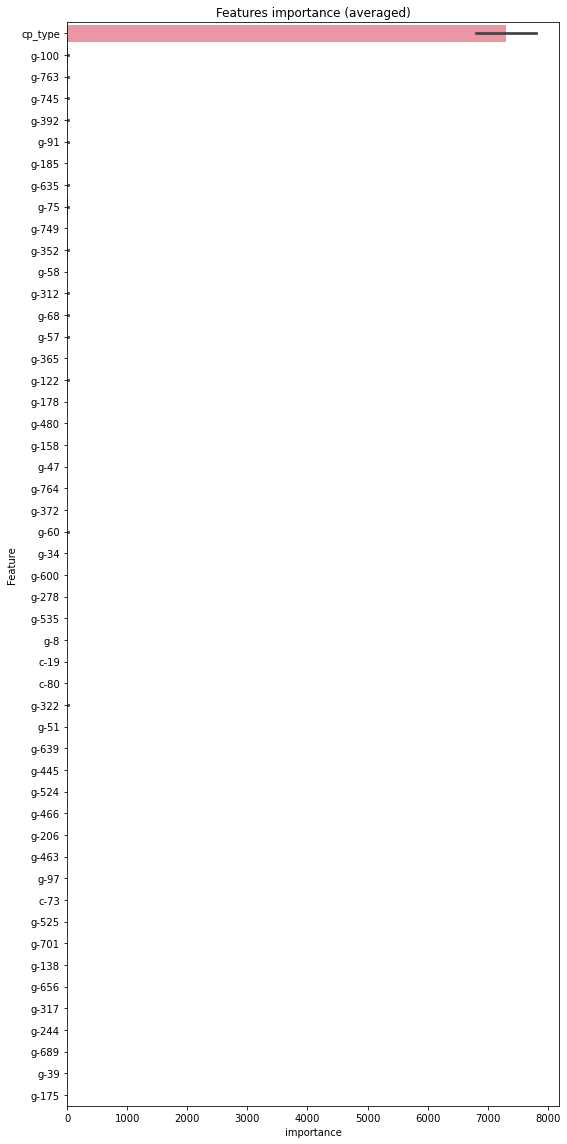

In [13]:
show_feature_importance(feature_importance_df)